In [189]:
import random
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import esda
import libpysal.weights as weights
from esda.moran import Moran
from esda.moran import Moran_Local
from shapely.geometry import Point, MultiPoint, LineString, Polygon, shape
import json
import pylab
import networkx as nx
import libpysal
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.birch import birch
from pyclustering.cluster.cure import cure
from pyclustering.cluster.dbscan import dbscan
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.optics import optics
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import copy

# Util Functions

In [53]:
def save_data_for_sticc(data, knn, coord, filename):
    o = open(filename, "w")
    #o.write("attr1,attr2,attr3,attr4,attr5,n_pt_0,n_pt_1,n_pt_2")
    for i in range(data.shape[0]):
        feat_str = ",".join([str(j) for j in data[i]]).replace("nan","")
        nbs = ",".join([str(j) for j in knn[i]])
        locs = ",".join([str(j) for j in coord[i]])
        o.write("{},{},{}\n".format(feat_str, nbs, locs))
        
    o.close()

In [435]:
def load_data(defect_rate, idx):
    data = np.load("defective_data/synthetic-data-r-{:.2f}-{:d}.npz".format(defect_rate, idx))
    
    ground_truth = data["gt"]
    clean_features = data["clean"]
    missing_mask = data["missing"]
    extreme_features = data["extreme"]
    ood_features = data["ood"]
    
    print(np.sum(missing_mask) / (missing_mask.shape[0] * missing_mask.shape[1]))
    
    missing_features = copy.deepcopy(clean_features)
    missing_features[missing_mask==1] = np.nan
    
    coord = ground_truth[:,:2]
    
    pts_all = []
    for x, y in ground_truth[:,:2]:
        pts_all.append((x, y))
    kd = libpysal.cg.KDTree(np.array(pts_all))
    wnn = libpysal.weights.KNN(kd, 30)
    
    nearest_pt = pd.DataFrame().from_dict(wnn.neighbors, orient="index")
    nearest_pt = nearest_pt.to_numpy()
    
    #dropped_features = copy.deepcopy(clean_features)
    #dropped_features = dropped_features[(~np.isnan(missing_features)).all(axis=1)]
    
    #dropped_coord = (ground_truth[:,:2])[(~np.isnan(missing_features)).all(axis=1)]
    
    #pts_all = []
    #for x, y in dropped_coord:
    #    pts_all.append((x, y))
    #kd = libpysal.cg.KDTree(np.array(pts_all))
    #wnn = libpysal.weights.KNN(kd, 30)
    
    #dropped_nearest_pt = pd.DataFrame().from_dict(wnn.neighbors, orient="index")
    #dropped_nearest_pt = dropped_nearest_pt.to_numpy()
    
    save_data_for_sticc(clean_features, nearest_pt, coord, "synthetic-data-clean-{:.2f}-{:d}.txt".format(defect_rate, idx))
    save_data_for_sticc(missing_features, nearest_pt, coord, "synthetic-data-missing-{:.2f}-{:d}.txt".format(defect_rate, idx))
    save_data_for_sticc(extreme_features, nearest_pt, coord, "synthetic-data-extreme-{:.2f}-{:d}.txt".format(defect_rate, idx))
    save_data_for_sticc(ood_features, nearest_pt, coord, "synthetic-data-ood-{:.2f}-{:d}.txt".format(defect_rate, idx))
    #save_data_for_sticc(dropped_features, dropped_nearest_pt, dropped_coord, "synthetic-data-dropped-{:.2f}.txt".format(defect_rate))

# Sanity Check

In [187]:
data = np.load("defective_data/synthetic-data-clean.npz")

In [199]:
ground_truth = data["gt"]
clean_features = data["clean"]

In [224]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=2.1, min_samples=10).fit(clean_features)

Counter(clustering.labels_)

Counter({0: 703, -1: 23, 1: 196, 2: 197, 3: 94})

In [225]:
print("ARI", adjusted_rand_score(clustering.labels_, ground_truth[:,2]))

ARI 0.40593775710661634


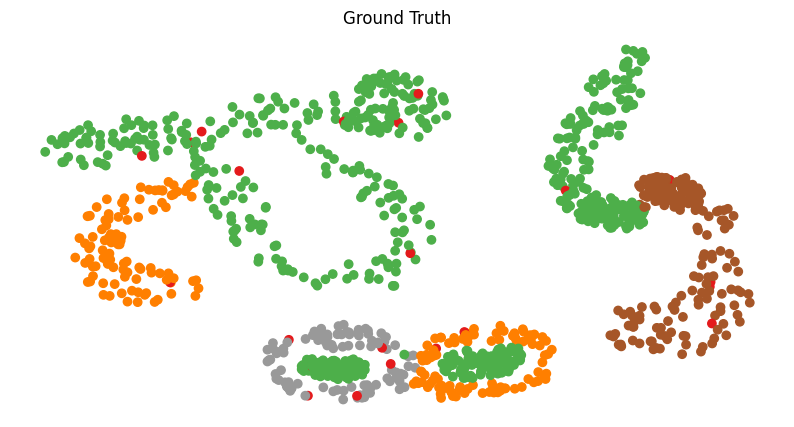

In [226]:
fig, ax = plt.subplots(figsize=(10, 5))
markersize = 10
plt.scatter(ground_truth[:,0], ground_truth[:,1], c=clustering.labels_, cmap="Set1")
ax.set_axis_off()
ax.title.set_text('Ground Truth')

In [203]:
pts_all = []
for x, y in ground_truth[:,:2]:
    pts_all.append((x, y))
kd = libpysal.cg.KDTree(np.array(pts_all))
wnn = libpysal.weights.KNN(kd, 30)

/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [201]:
nearest_pt = pd.DataFrame().from_dict(wnn.neighbors, orient="index")
for i in range(nearest_pt.shape[1]):
    nearest_pt = nearest_pt.rename({i:f"n_pt_{i}"}, axis=1)
nearest_pt.head(1)

n_pt_0  n_pt_1  n_pt_2  n_pt_3  n_pt_4  n_pt_5  n_pt_6  n_pt_7  n_pt_8  \
0      41      78      45      53      57      86      12      48       7   

   n_pt_9  ...  n_pt_20  n_pt_21  n_pt_22  n_pt_23  n_pt_24  n_pt_25  n_pt_26  \
0      88  ...       23       42        6       33        8       43       68   

   n_pt_27  n_pt_28  n_pt_29  
0       21       36       51  

[1 rows x 30 columns]

In [204]:
nearest_pt = nearest_pt.to_numpy()

In [205]:
save_data_for_sticc(clean_features, nearest_pt, "synthetic-data-clean.txt")

In [237]:
!rm -rf result-synthetic-data-clean-glasso.txt
!python STICC_main.py --fname=synthetic-data-clean.txt --oname=result-synthetic-data-clean-glasso.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method glasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 35)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({2: 208, 5: 205, 4: 202, 3: 199, 1: 186, 6: 114, 0: 99})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 99
length of the cluster  1 ------> 186
length of the cluster  2 ------> 208
length of the cluster  3 ------> 199
length of the cluster  4 ------> 202
length of the cluster  5 ------> 205
length of the cluster  6 ------> 114
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[1386.3618 71.4554 84.4303 ... 267.8165 45.5325 65.2156]
 [1619.4941 92.2166 151.9997 ... 163.6002 50.6924 71.7798]
 [1424.6167 61.7849 68.1764 ...

ARI 0.9414052545288581


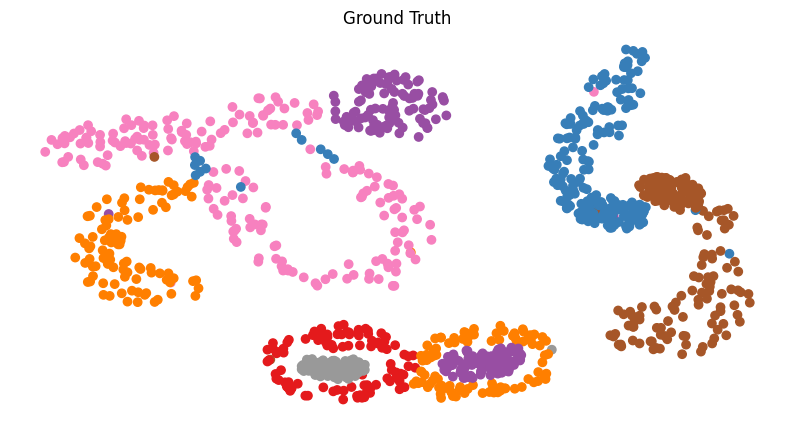

In [238]:
get_sticc_result(ground_truth, 'result-synthetic-data-clean-glasso.txt', title='STICC')

In [236]:
clean_features

array([[-4.63762524,  3.19868586, -1.99081986, -3.61398301, -1.65939956],
       [-4.9642345 ,  3.63652416, -3.35620688, -3.91589443, -1.65640154],
       [-4.49626618,  1.57241837, -2.56886018, -3.04337788, -0.34753234],
       ...,
       [-4.14737904,  4.41584439, -1.65210242, -3.61550424, -2.45562591],
       [-1.91820472,  1.84396035, -2.80641632, -3.57080826, -1.14103818],
       [-4.04709302,  3.57831396, -2.63529795, -3.69637456, -2.76425757]])

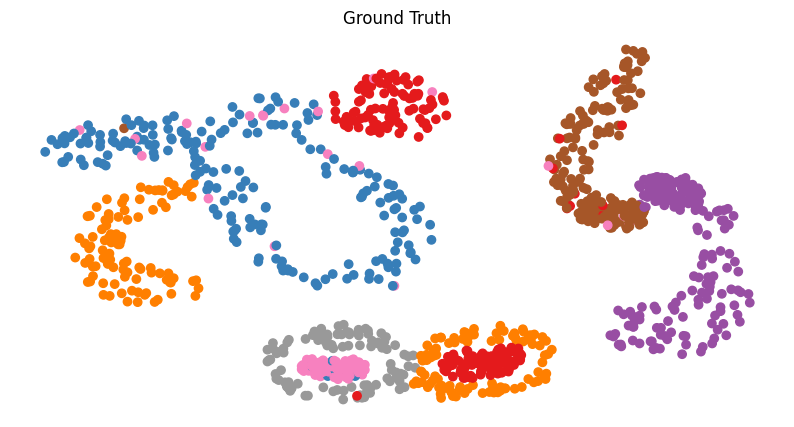

In [230]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, n_init=300).fit(clean_features)
fig, ax = plt.subplots(figsize=(10, 5))
markersize = 10
plt.scatter(ground_truth[:,0], ground_truth[:,1], c=kmeans.labels_, cmap="Set1")
ax.set_axis_off()
ax.title.set_text('Ground Truth')

In [232]:
Counter(kmeans.labels_)

Counter({1: 204, 5: 115, 4: 186, 0: 208, 3: 199, 2: 202, 6: 99})

In [231]:
print("ARI", adjusted_rand_score(kmeans.labels_, ground_truth[:,2]))

ARI 0.9299880652231636


# Load Data

In [181]:
defect_rate = "0.30"

In [182]:
data = np.load("defective_data/synthetic-data-r-{}.npz".format(defect_rate))

In [183]:
ground_truth = data["gt"]
clean_features = data["clean"]
missing_mask = data["missing"]
extreme_features = data["extreme"]
ood_features = data["ood"]

In [364]:
Counter(np.sum(missing_mask, axis=1))

Counter({1: 433, 3: 179, 2: 364, 0: 196, 4: 40, 5: 1})

In [184]:
print(np.sum(missing_mask) / (missing_mask.shape[0] * missing_mask.shape[1]))

0.30717230008244023


In [186]:
missing_features = copy.deepcopy(clean_features)
missing_features[missing_mask==1] = np.nan

In [187]:
nidx = (~np.isnan(missing_features)).all(axis=1)

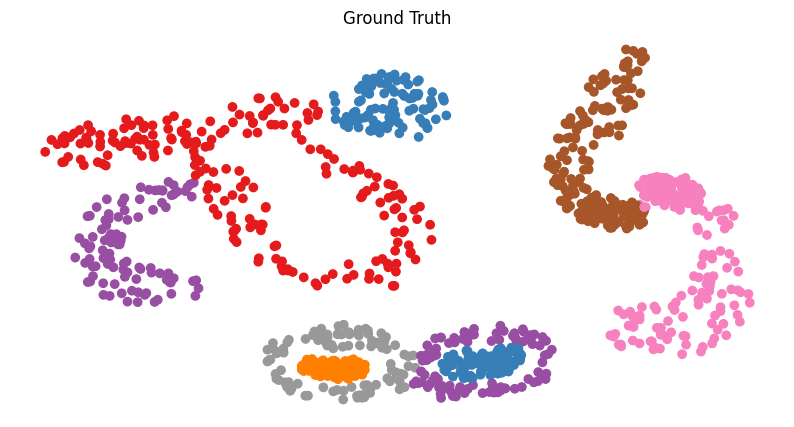

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
markersize = 10
plt.scatter(ground_truth[:,0], ground_truth[:,1], c=ground_truth[:,2], cmap="Set1")
ax.set_axis_off()
ax.title.set_text('Ground Truth')

In [10]:
pts_all = []
for x, y in ground_truth[:,:2]:
    pts_all.append((x, y))
kd = libpysal.cg.KDTree(np.array(pts_all))
wnn = libpysal.weights.KNN(kd, 30)

/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [11]:
nearest_pt = pd.DataFrame().from_dict(wnn.neighbors, orient="index")
for i in range(nearest_pt.shape[1]):
    nearest_pt = nearest_pt.rename({i:f"n_pt_{i}"}, axis=1)
nearest_pt.head(1)

n_pt_0  n_pt_1  n_pt_2  n_pt_3  n_pt_4  n_pt_5  n_pt_6  n_pt_7  n_pt_8  \
0      41      78      45      53      57      86      12      48       7   

   n_pt_9  ...  n_pt_20  n_pt_21  n_pt_22  n_pt_23  n_pt_24  n_pt_25  n_pt_26  \
0      88  ...       23       42        6       33        8       43       68   

   n_pt_27  n_pt_28  n_pt_29  
0       21       36       51  

[1 rows x 30 columns]

In [12]:
nearest_pt = nearest_pt.to_numpy()

In [330]:
save_data_for_sticc(clean_features, nearest_pt, "synthetic-data-clean-{}.txt".format(defect_rate))

In [331]:
save_data_for_sticc(missing_features, nearest_pt, "synthetic-data-missing-{}.txt".format(defect_rate))

In [332]:
save_data_for_sticc(extreme_features, nearest_pt, "synthetic-data-extreme-{}.txt".format(defect_rate))

In [333]:
save_data_for_sticc(ood_features, nearest_pt, "synthetic-data-ood-{}.txt".format(defect_rate))

In [334]:
print(np.sum(np.abs(extreme_features - clean_features)))
print(np.sum(np.abs(ood_features - clean_features)))

2152.84424226146
11210.229148534429


# STICC

In [240]:
def get_sticc_result(ground_truth, filename, title='STICC'):
    pred_labels = pd.read_table(filename, names=["group"])
    
#     fig, ax = plt.subplots(figsize=(10, 5))
#     markersize = 10
#     plt.scatter(ground_truth[:,0], ground_truth[:,1], c=pred_labels.group, cmap="Set1")
#     ax.set_axis_off()
#     ax.title.set_text('Ground Truth')

#     print("ARI", adjusted_rand_score(pred_labels.group, ground_truth[:,2]))
#     print("NMI", normalized_mutual_info_score(pred_labels.group, ground_truth[:,2]))
    
    return adjusted_rand_score(pred_labels.group, ground_truth[:,2]), normalized_mutual_info_score(pred_labels.group, ground_truth[:,2])
    
    #sp_contiguity = cal_joint_statistic(synthetic_data_sticc, w_voronoi)
    #print("Spatial contiguity: ", sp_contiguity)
    
    #get_max_f1_score(synthetic_data_sticc)
    
    #return synthetic_data_sticc

## Clean Values

In [193]:
!rm -rf result-synthetic-data-clean-glasso-0.30.txt
!python STICC_main.py --fname=synthetic-data-clean-0.30.txt --oname=result-synthetic-data-clean-glasso-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=14 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method glasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 10)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({3: 214, 2: 203, 5: 201, 4: 197, 6: 167, 1: 131, 0: 100})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 100
length of the cluster  1 ------> 131
length of the cluster  2 ------> 203
length of the cluster  3 ------> 214
length of the cluster  4 ------> 197
length of the cluster  5 ------> 201
length of the cluster  6 ------> 167
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[633.1166 202.7968 170.5464 ... 170.3164 142.2048 187.2008]
 [779.2775 224.5204 175.5127 ... 238.5758 168.4785 181.8318]
 [732.1954 188.0342 159.

ARI 0.9622662683637698
NMI 0.9543267094829513


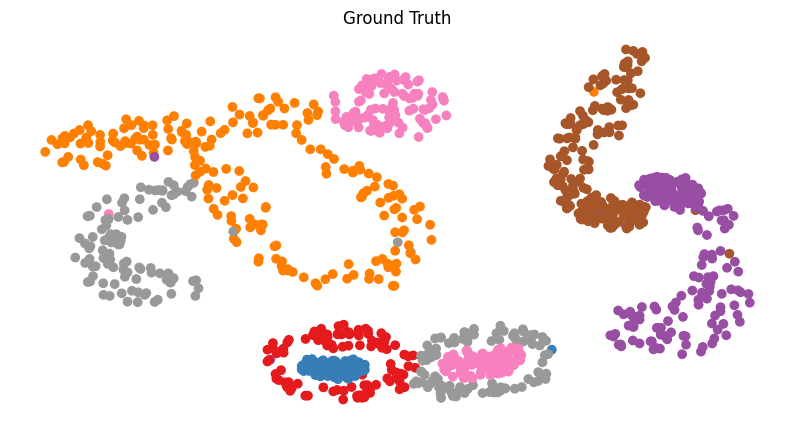

In [194]:
get_sticc_result(ground_truth, 'result-synthetic-data-clean-glasso-0.30.txt', title='STICC')

In [201]:
!rm -rf result-synthetic-data-clean-missglasso-0.30.txt
!python STICC_main.py --fname=synthetic-data-clean-0.30.txt --oname=result-synthetic-data-clean-missglasso-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=14 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso_random --local_radius=3 --init_random --defect_rate 0.2

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 10)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({3: 235, 2: 205, 1: 182, 0: 180, 5: 161, 6: 146, 4: 104})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 15)
(1213, 15)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 180
length of the cluster  1 ------> 182
length of the cluster  2 ------> 205
length of the cluster  3 ------> 235
length of the cluster  4 ------> 104
length

OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 200
length of the cluster  1 ------> 200
length of the cluster  2 ------> 212
length of the cluster  3 ------> 200
length of the cluster  4 ------> 100
length of the cluster  5 ------> 200
length of the cluster  6 ------> 101
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[125.6187 189.7130 55.7895 ... 1098.4476 819.7155 242.2893]
 [117.3769 187.4501 45.4740 ... 1211.9491 870.6080 280.0820]
 [104.2006 168.1628 39.7515 ... 1152.6967 847.6258 270.2581]
 ...
 [125.6802 139.2732 53.0352 ... 732.8822 503.0528 1920.5767]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 199
length of cluster # 1 --------> 201
length of cluster # 2 --------> 212
length of cluster # 3 --------> 200
length of cluster # 4 --------> 100
length of cluster # 5 --------> 200
length of cluster # 6 --------> 101







ITERATION ### 6
Start fitting Miss

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 15)
(1213, 15)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 198
length of the cluster  1 ------> 202
length of the cluster  2 ------> 212
length of the cluster  3 ------> 200
length of the cluster  4 ------> 100
length of the cluster  5 ------> 200
length of the cluster  6 ------> 101
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[140.2619 142.5414 56.0064 ... 991.5352 764.8932 239.0351]
 [146.2582 145.4018 44.3349 ... 1102.6561 781.0543 277.5888]
 [115.7557 126.4506 38.4362 ... 1043

ARI 0.8616520277252455
NMI 0.8978447443422518


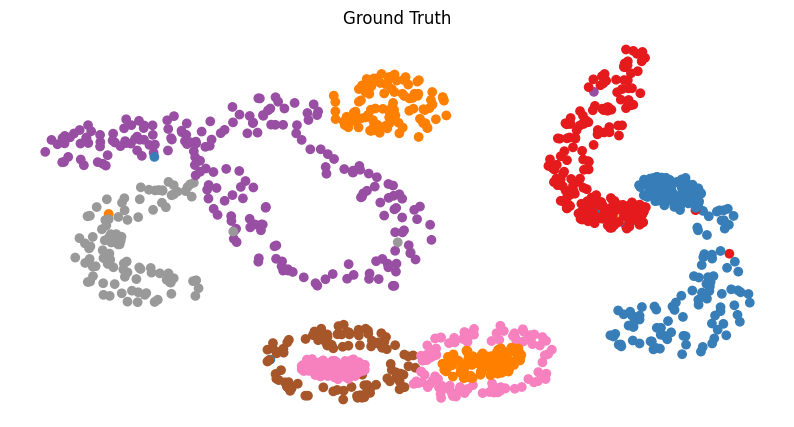

In [202]:
get_sticc_result(ground_truth, 'result-synthetic-data-clean-missglasso-0.30.txt', title='STICC')

ARI 0.9476848184279997
NMI 0.9530416280200441


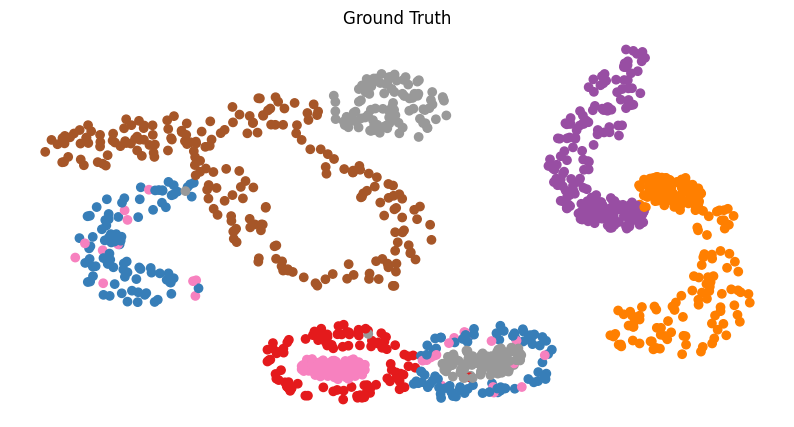

In [191]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, n_init=300).fit(clean_features)
fig, ax = plt.subplots(figsize=(10, 5))
markersize = 10
plt.scatter(ground_truth[:,0], ground_truth[:,1], c=kmeans.labels_, cmap="Set1")
ax.set_axis_off()
ax.title.set_text('Ground Truth')

print("ARI", adjusted_rand_score(kmeans.labels_, ground_truth[:,2]))
print("NMI", normalized_mutual_info_score(kmeans.labels_, ground_truth[:,2]))

## Missing Values

In [180]:
!rm -rf result-synthetic-data-missing-missglasso-0.30.txt
!python STICC_main.py --fname=synthetic-data-dropped-0.30.txt --oname=result-synthetic-data-missing-dropping-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method glasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(196, 37)
5 (196, 5) (196, 30)
(196, 37)
5
196
Complete D train shape:  (196, 15)
(196, 5)
Counter({3: 41, 4: 40, 1: 28, 5: 26, 0: 22, 6: 20, 2: 19})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 22
length of the cluster  1 ------> 28
length of the cluster  2 ------> 19
length of the cluster  3 ------> 41
length of the cluster  4 ------> 40
length of the cluster  5 ------> 26
length of the cluster  6 ------> 20
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[178.6559 25.9619 706.5961 ... 169.8686 224.8208 408.3780]
 [523.7562 40.7669 1382.7310 ... 282.5974 211.9373 1724.9585]
 [192.4255 37.8646 789.6934 ... 192.4263 286.

In [188]:
pred_labels = pd.read_table('result-synthetic-data-missing-dropping-0.30.txt', names=["group"])

print("ARI", adjusted_rand_score(pred_labels.group, (ground_truth[nidx])[:,2]))

ARI 0.7799689145142816


In [68]:
!rm -rf result-synthetic-data-missing-missglasso-0.30.txt
!python STICC_main.py --fname=synthetic-data-missing-0.30.txt --oname=result-synthetic-data-missing-missglasso-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso --local_radius 3

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Start fitting MissGLasso Model
(1213, 5)
Counter({3: 250, 4: 200, 2: 190, 6: 173, 1: 156, 5: 139, 0: 105})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 105
length of the cluster  1 ------> 156
length of the cluster  2 ------> 190
length of the cluster  3 ------> 250
length of the cluster  4 ------> 200
length

ARI 0.8628849518370868


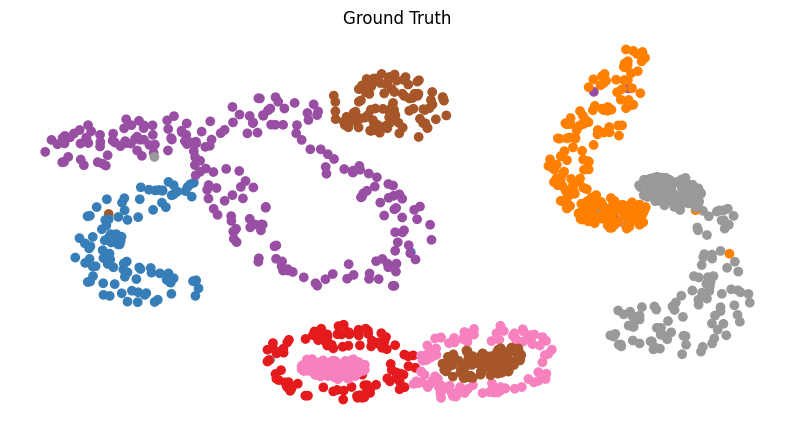

In [69]:
get_sticc_result(ground_truth, 'result-synthetic-data-missing-missglasso-0.30.txt', title='STICC')

In [157]:
!rm -rf result-synthetic-data-missing-missglasso-0.30.txt
!python STICC_main.py --fname=synthetic-data-missing-0.30.txt --oname=result-synthetic-data-missing-missglasso-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso --local_radius 3

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Start fitting MissGLasso Model
(1213, 5)
Counter({3: 216, 6: 210, 4: 190, 1: 178, 2: 156, 5: 152, 0: 111})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 111
length of the cluster  1 ------> 178
length of the cluster  2 ------> 156
length of the cluster  3 ------> 216
length of the cluster  4 ------> 190
length

OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 100
length of the cluster  1 ------> 202
length of the cluster  2 ------> 99
length of the cluster  3 ------> 198
length of the cluster  4 ------> 214
length of the cluster  5 ------> 200
length of the cluster  6 ------> 200
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[953.1867 116.1435 288.3063 ... 57.4726 606.3683 160.4471]
 [1023.6623 115.8083 333.7768 ... 52.1807 677.6461 176.0381]
 [1003.2288 97.9333 304.8266 ... 41.4169 649.6116 165.0034]
 ...
 [717.9681 79.6060 2172.4416 ... 57.4264 367.8267 205.6122]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 100
length of cluster # 1 --------> 202
length of cluster # 2 --------> 99
length of cluster # 3 --------> 198
length of cluster # 4 --------> 214
length of cluster # 5 --------> 200
length of cluster # 6 --------> 200








CONVERGED!!! BREAKING EARLY!!!
[4.0000

ARI 0.8649755812148853


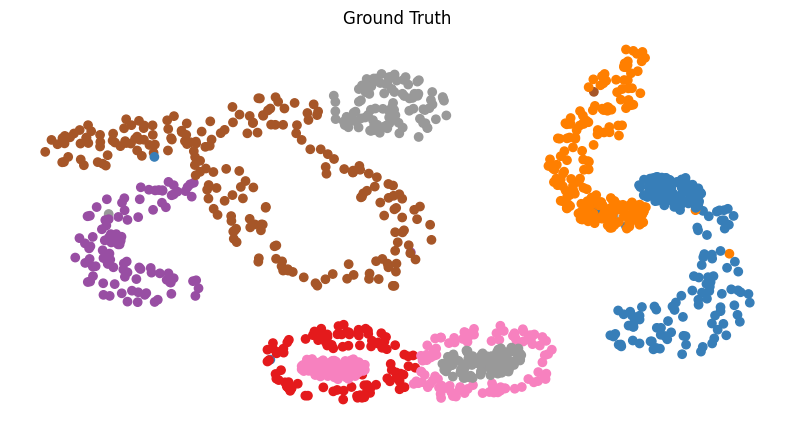

In [158]:
get_sticc_result(ground_truth, 'result-synthetic-data-missing-missglasso-0.30.txt', title='STICC')

ARI 0.9664239269966722


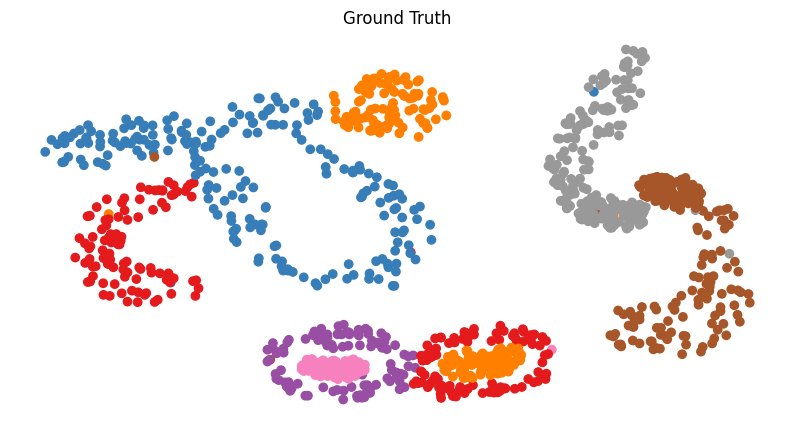

In [370]:
get_sticc_result(ground_truth, 'result-synthetic-data-missing-missglasso-0.30.txt', title='STICC')

## Extreme Values

ARI 0.913166582171722


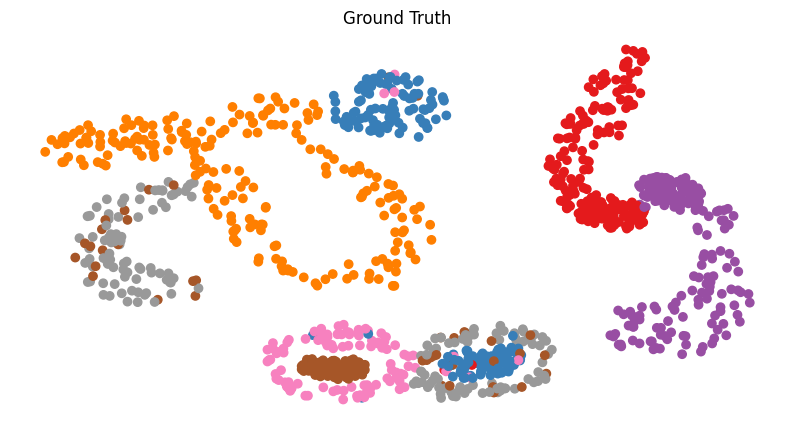

In [371]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, n_init=300).fit(extreme_features)
fig, ax = plt.subplots(figsize=(10, 5))
markersize = 10
plt.scatter(ground_truth[:,0], ground_truth[:,1], c=kmeans.labels_, cmap="Set1")
ax.set_axis_off()
ax.title.set_text('Ground Truth')

print("ARI", adjusted_rand_score(kmeans.labels_, ground_truth[:,2]))

In [380]:
Counter(kmeans.labels_)

Counter({3: 214, 1: 188, 5: 104, 4: 142, 6: 162, 0: 200, 2: 203})

In [372]:
!rm -rf result-synthetic-data-extreme-glasso-0.30.txt
!python STICC_main.py --fname=synthetic-data-extreme-0.30.txt --oname=result-synthetic-data-extreme-glasso-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=14 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method glasso

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 35)
5 (1213, 5) (1213, 10)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({2: 214, 3: 203, 0: 200, 1: 188, 4: 162, 6: 142, 5: 104})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 200
length of the cluster  1 ------> 188
length of the cluster  2 ------> 214
length of the cluster  3 ------> 203
length of the cluster  4 ------> 162
length of the cluster  5 ------> 104
length of the cluster  6 ------> 142
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[155.5847 145.8349 51.2890 ... 184.8036 202.7995 174.4670]
 [215.2005 136.1830 56.2316 ... 137.2373 220.0673 143.8837]
 [208.5137 138.2108 54.310

length of cluster # 0 --------> 198
length of cluster # 1 --------> 200
length of cluster # 2 --------> 214
length of cluster # 3 --------> 202
length of cluster # 4 --------> 106
length of cluster # 5 --------> 100
length of cluster # 6 --------> 193







ITERATION ### 7
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 198
length of the cluster  1 ------> 200
length of the cluster  2 ------> 214
length of the cluster  3 ------> 202
length of the cluster  4 ------> 106
length of the cluster  5 ------> 100
length of the cluster  6 ------> 193
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[82.3897 132.0118 50.3508 ... 106.8926 1217.6857 895.3729]
 [156.6372 144.2555 56.8850 ... 102.2161 1387.0718 784.5373]
 [155.3045 145.9662 54.

ARI 0.8616520277252455


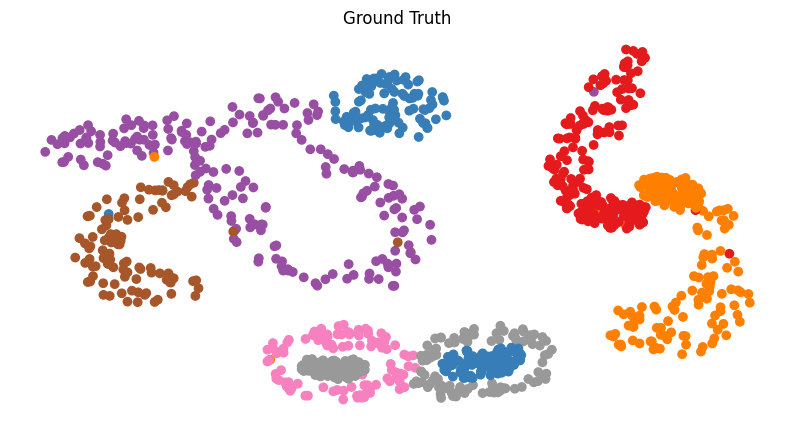

In [374]:
get_sticc_result(ground_truth, 'result-synthetic-data-extreme-glasso-0.30.txt', title='STICC')

In [383]:
!rm -rf result-synthetic-data-extreme-missglasso-0.30.txt
!python STICC_main.py --fname=synthetic-data-extreme-0.30.txt --oname=result-synthetic-data-extreme-missglasso-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso_random --defect_rate 0.3

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Counter({4: 214, 2: 203, 1: 200, 3: 188, 5: 162, 0: 142, 6: 104})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 142
length of the cluster  1 ------> 200
length of the cluster  2 ------> 203
length of the cluster  3 ------> 188
length of the cluster  4 ------> 214
length of the cluster  5 ------> 162
length of the cluster  6 ---

OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 100
length of the cluster  1 ------> 199
length of the cluster  2 ------> 201
length of the cluster  3 ------> 200
length of the cluster  4 ------> 211
length of the cluster  5 ------> 202
length of the cluster  6 ------> 100
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[1775.5870 101.2762 155.5001 ... 45.4984 95.1709 1151.0156]
 [1853.4647 121.2749 156.9426 ... 53.2639 105.7602 1379.0790]
 [1789.5586 180.4472 256.1751 ... 58.1711 101.7720 1200.1391]
 ...
 [837.7267 134.2331 169.0115 ... 54.4271 97.3021 725.5598]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 100
length of cluster # 1 --------> 200
length of cluster # 2 --------> 200
length of cluster # 3 --------> 200
length of cluster # 4 --------> 212
length of cluster # 5 --------> 201
length of cluster # 6 --------> 100







ITERATION ### 6
Start fitting Miss

length of cluster # 3 --------> 200
length of cluster # 4 --------> 215
length of cluster # 5 --------> 198
length of cluster # 6 --------> 100







ITERATION ### 11
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 100
length of the cluster  1 ------> 198
length of the cluster  2 ------> 202
length of the cluster  3 ------> 200
length of the cluster  4 ------> 215
length of the cluster  5 ------> 198
length of the cluster  6 ------> 100
UPDATED THE OLD COVAR

[[1786.4046 80.3599 99.9089 ... 46.1758 122.8723 1146.7228]
 [1820.3235 180.9349 171.6567 ... 54.8623 129.9343 1321.7187]
 [1825.3198 144.5359 119.3115 ... 49.7457 117.4963 1193.3286]
 ...
 [905.6125 142.4106 135.2759 ... 57.4048 120.0464 730.9247]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 100
length of cluster # 1 --------> 199
length of cluster # 2 --------> 201
length of cluster # 3 --------> 200
length of cluster # 4 --------> 213
length of cluster # 5 --------> 200
length of cluster # 6 --------> 100







ITERATION ### 17
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZAT

ARI 0.9621780347769653


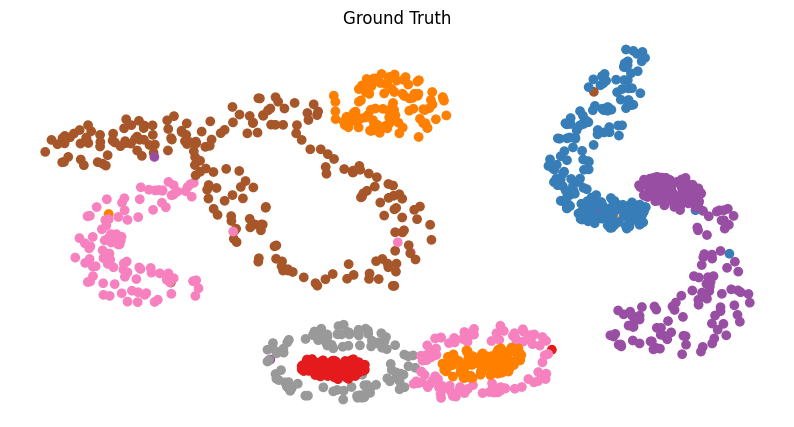

In [384]:
get_sticc_result(ground_truth, 'result-synthetic-data-extreme-missglasso-0.30.txt', title='STICC')

## OOD Values

ARI 0.18009676834077873


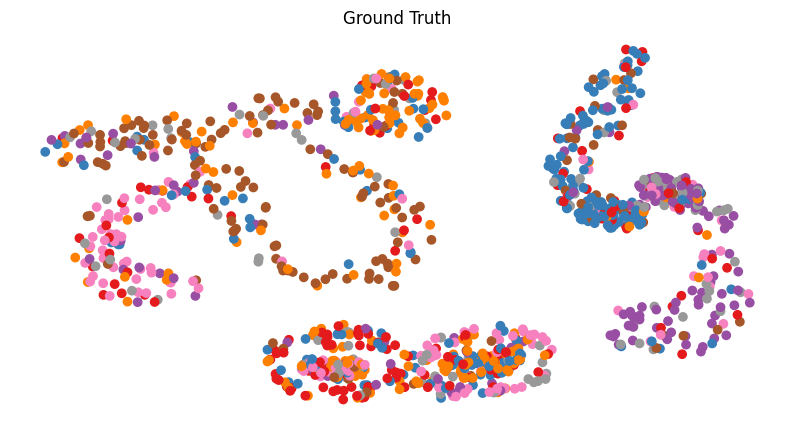

In [385]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, n_init=300).fit(ood_features)
fig, ax = plt.subplots(figsize=(10, 5))
markersize = 10
plt.scatter(ground_truth[:,0], ground_truth[:,1], c=kmeans.labels_, cmap="Set1")
ax.set_axis_off()
ax.title.set_text('Ground Truth')

print("ARI", adjusted_rand_score(kmeans.labels_, ground_truth[:,2]))

In [ ]:
Counter(kmeans.labels_)

In [386]:
!rm -rf result-synthetic-data-ood-glasso-0.30.txt
!python STICC_main.py --fname=synthetic-data-ood-0.30.txt --oname=result-synthetic-data-ood-glasso-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=14 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method glasso 

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 35)
5 (1213, 5) (1213, 10)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({5: 242, 6: 197, 3: 167, 2: 165, 1: 156, 0: 154, 4: 132})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 154
length of the cluster  1 ------> 156
length of the cluster  2 ------> 165
length of the cluster  3 ------> 167
length of the cluster  4 ------> 132
length of the cluster  5 ------> 242
length of the cluster  6 ------> 197
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[70.1724 73.9930 64.0662 ... 75.2054 79.1789 72.3509]
 [80.0191 82.7882 85.3049 ... 89.5973 77.7979 75.1260]
 [69.8036 68.6922 75.4376 ... 81.268

length of cluster # 0 --------> 99
length of cluster # 1 --------> 44
length of cluster # 2 --------> 385
length of cluster # 3 --------> 109
length of cluster # 4 --------> 173
length of cluster # 5 --------> 113
length of cluster # 6 --------> 290







ITERATION ### 7
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 99
length of the cluster  1 ------> 44
length of the cluster  2 ------> 385
length of the cluster  3 ------> 109
length of the cluster  4 ------> 173
length of the cluster  5 ------> 113
length of the cluster  6 ------> 290
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[72.2943 83.5355 111.0010 ... 124.0292 133.6687 69.0009]
 [77.7194 78.8408 127.1539 ... 121.1949 144.4290 81.3636]
 [65.3501 77.9320 117.9183 ... 1

length of cluster # 0 --------> 89
length of cluster # 1 --------> 98
length of cluster # 2 --------> 291
length of cluster # 3 --------> 114
length of cluster # 4 --------> 193
length of cluster # 5 --------> 207
length of cluster # 6 --------> 221







ITERATION ### 14
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 89
length of the cluster  1 ------> 98
length of the cluster  2 ------> 291
length of the cluster  3 ------> 114
length of the cluster  4 ------> 193
length of the cluster  5 ------> 207
length of the cluster  6 ------> 221
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[75.8268 90.1161 191.7744 ... 121.8266 328.7774 65.6921]
 [78.6917 100.0499 222.6431 ... 120.9668 342.2346 76.0901]
 [64.7877 80.0775 195.3737 ...

ARI 0.3651194766760763


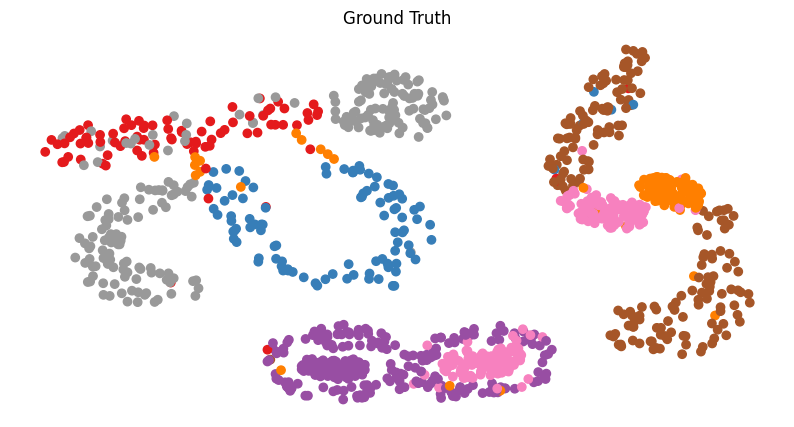

In [387]:
get_sticc_result(ground_truth, 'result-synthetic-data-ood-glasso-0.30.txt', title='STICC')

In [401]:
!rm -rf result-synthetic-data-ood-missglasso-0.30.txt
!python STICC_main.py --fname=synthetic-data-ood-0.30.txt --oname=result-synthetic-data-ood-missglasso-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso_random --defect_rate 0.10

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
False
No initial random fitting
Counter({5: 238, 4: 205, 3: 169, 2: 167, 6: 156, 0: 148, 1: 130})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 148
length of the cluster  1 ------> 130
length of the cluster  2 ------> 167
length of the cluster  3 ------> 169
length of the cluster  4 ------> 205
length of the cluster  5 ------> 

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 141
length of the cluster  1 ------> 79
length of the cluster  2 ------> 200
length of the cluster  3 ------> 326
length of the cluster  4 ------> 246
length of the cluster  5 ------> 159
length of the cluster  6 ------> 62
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[65.0956 70.4823 74.0539 ... 64.9192 73.9881 74.7574]
 [71.8701 79.5645 88.4395 ... 74.6432 79.9943 81.7446]
 [65.6792 69.3819 81.5380 ... 64.7445 74.9244 67.5990]
 ...
 [79.0119 84.6848 79.4520 ... 151.7518 80.8158 117.9282]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.000

Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 177
length of the cluster  1 ------> 123
length of the cluster  2 ------> 109
length of the cluster  3 ------> 388
length of the cluster  4 ------> 281
length of the cluster  5 ------> 121
length of the cluster  6 ------> 14
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[78.7289 85.4974 124.9182 ... 64.8806 93.3297 68.2201]
 [90.2661 107.7782 136.3474 ... 73.8493 106.7230 95.8207]
 [68.8440 84.5052 134.5792 ... 66.1960 84.8486 71.2378]
 ...
 [149.9623 148.6770 79.7854 ... 246.3498 77.9042 161.6766]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of c

length of cluster # 0 --------> 187
length of cluster # 1 --------> 107
length of cluster # 2 --------> 117
length of cluster # 3 --------> 354
length of cluster # 4 --------> 208
length of cluster # 5 --------> 145
length of cluster # 6 --------> 95







ITERATION ### 15
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 187
length of the cluster  1 ------> 107
length of the cluster  2 ------> 117
length of the cluster  3 ------> 354
length of the cluster  4 

ARI 0.36481716901387656


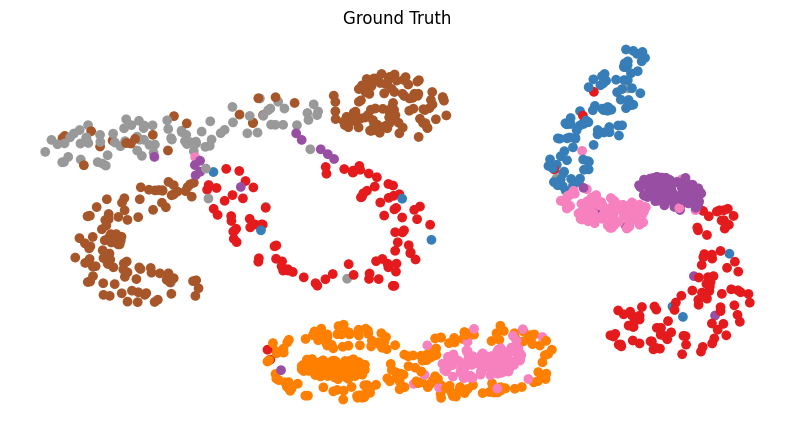

In [402]:
get_sticc_result(ground_truth, 'result-synthetic-data-ood-missglasso-0.30.txt', title='STICC')

In [396]:
!rm -rf result-synthetic-data-ood-missglasso-init-0.30.txt
!python STICC_main.py --fname=synthetic-data-ood-0.30.txt --oname=result-synthetic-data-ood-missglasso-init-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso_random --defect_rate 0.10 --init_random

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Start fitting MissGLasso Model
Counter({1: 236, 3: 205, 0: 184, 6: 167, 2: 155, 5: 144, 4: 122})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 184
length of the cluster  1 ------> 236
length of the cluster  2 ------> 155
length of the cluster  3 ------> 205
length of the cluster  4 ------> 122
length of the cluster  5 ------> 1

[[76.8603 74.3383 69.3532 ... 76.7726 108.0362 106.4468]
 [95.7950 83.1556 77.1376 ... 89.5983 117.9686 131.0171]
 [86.7986 79.1031 65.1381 ... 80.8663 111.0851 121.6655]
 ...
 [79.3723 80.0735 107.2869 ... 125.3075 73.5757 78.9989]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 152
length of cluster # 1 --------> 178
length of cluster # 2 --------> 103
length of cluster # 3 --------> 297
length of cluster # 4 --------> 122
length of cluster # 5 --------> 110
length of cluster # 6 --------> 251







ITERATION ### 6
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster #

Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 195
length of the cluster  1 ------> 110
length of the cluster  2 ------> 98
length of the cluster  3 ------> 308
length of the cluster  4 ------> 194
length of the cluster  5 ------> 106
length of the cluster  6 ------> 202
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[348.4586 165.6685 74.2350 ... 124.3239 132.0559 99.0202]
 [325.3395 197.9484 77.3951 ... 120.6402 131.9117 124.7717]
 [311.4871 176.2459 64.3393 ... 120.0719 133.1601 124.6723]
 ...
 [160.0076 85.9619 111.1865 ... 210.2006 77.8696 83.7058]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000

length of cluster # 0 --------> 195
length of cluster # 1 --------> 105
length of cluster # 2 --------> 104
length of cluster # 3 --------> 298
length of cluster # 4 --------> 197
length of cluster # 5 --------> 108
length of cluster # 6 --------> 206







ITERATION ### 17
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 195
length of the cluster  1 ------> 105
length of the cluster  2 ------> 104
length of the cluster  3 ------> 298
length of the cluster  4

ARI 0.39406732289897584


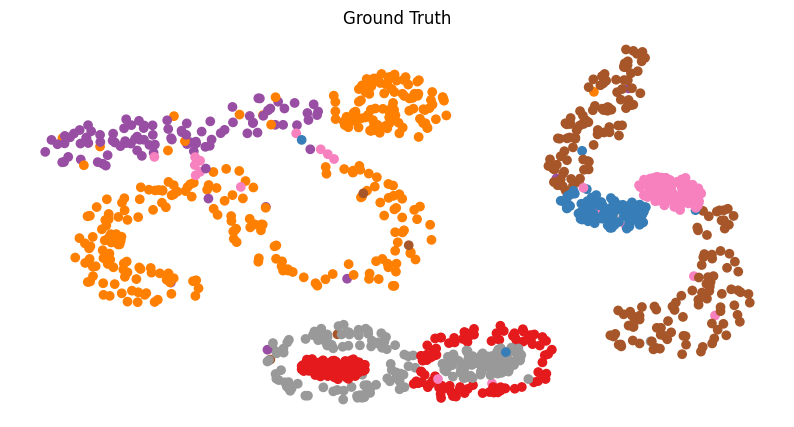

In [397]:
get_sticc_result(ground_truth, 'result-synthetic-data-ood-missglasso-init-0.30.txt', title='STICC')

In [403]:
!rm -rf result-synthetic-data-ood-missglasso-0.30.txt
!python STICC_main.py --fname=synthetic-data-ood-0.30.txt --oname=result-synthetic-data-ood-missglasso-globalmean-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso_random --defect_rate 0.10 --init_random --interp global_mean

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Counter({1: 237, 3: 206, 4: 167, 2: 166, 6: 154, 0: 152, 5: 131})



ITERATION ### 0
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 152
length of the cluster  1 ------> 237
length of the cluster  2 ------> 166
length of the cluster  3 ------> 206
length of the cluster  4 ------> 167
length of the cluster  5 ------> 131
length of the cluster  6 ------> 154
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[75.6890 78.8788 70.7450 ... 63.9034 72.9450 70.3535]
 [74.2875 70.3329 77.2447 ... 75.7452 80.3092 68.7843]
 [69.84

[[107.7319 73.8570 85.0033 ... 105.7784 2837.3375 71.6732]
 [129.4845 82.3136 93.3966 ... 121.9670 3030.6772 76.2586]
 [137.7153 74.8034 86.8029 ... 113.0372 2325.7613 64.6358]
 ...
 [118.1375 77.2885 79.0553 ... 90.2325 6857.9137 101.0756]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 166
length of cluster # 1 --------> 188
length of cluster # 2 --------> 119
length of cluster # 3 --------> 311
length of cluster # 4 --------> 330
length of cluster # 5 --------> 4
length of cluster # 6 --------> 95







ITERATION ### 7
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 166
length of the cl

OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 208
length of the cluster  1 ------> 193
length of the cluster  2 ------> 118
length of the cluster  3 ------> 307
length of the cluster  4 ------> 285
length of the cluster  5 ------> 2
length of the cluster  6 ------> 100
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[115.7531 73.6372 113.3296 ... 109.3357 140321.3648 70.6139]
 [145.6259 79.8865 134.2392 ... 124.6302 224554.9439 73.6244]
 [150.0968 71.5803 124.5574 ... 124.6734 109930.4030 63.6218]
 ...
 [112.5324 76.8312 77.2687 ... 87.8930 1150555.8088 106.7037]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
cluster that is zero is: 5 selected cluster instead is: 1
length of c

[[115.2126 94.0518 115.5898 ... 104.3443 264.6458 71.4246]
 [153.4888 103.5797 129.6973 ... 132.5062 301.9790 82.0527]
 [149.2080 94.3737 121.0445 ... 128.8467 268.9084 66.1252]
 ...
 [117.1131 156.9085 79.6600 ... 82.9679 85.8338 112.8672]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 195
length of cluster # 1 --------> 102
length of cluster # 2 --------> 111
length of cluster # 3 --------> 302
length of cluster # 4 --------> 238
length of cluster # 5 --------> 166
length of cluster # 6 --------> 99




[3.0000 3.0000 6.0000 ... 2.0000 2.0000 2.0000]


ARI 0.35253820030965227


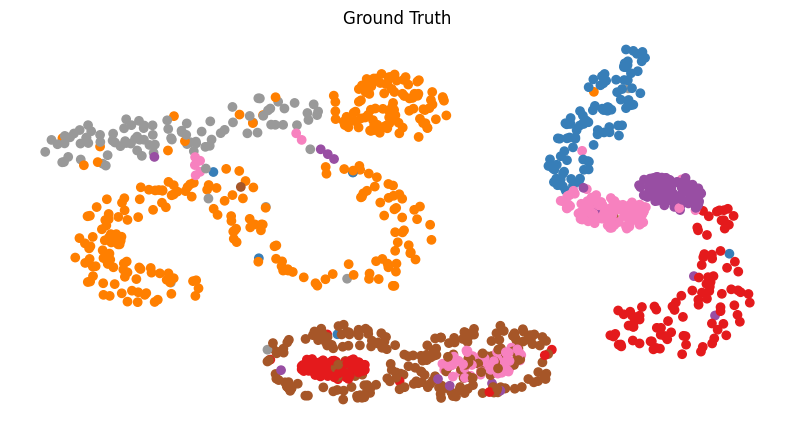

In [404]:
get_sticc_result(ground_truth, 'result-synthetic-data-ood-missglasso-globalmean-0.30.txt', title='STICC')

In [405]:
!rm -rf result-synthetic-data-ood-missglasso-0.30.txt
!python STICC_main.py --fname=synthetic-data-ood-0.30.txt --oname=result-synthetic-data-ood-missglasso-localmean-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso_random --defect_rate 0.10 --init_random --interp local_mean --local_radius 10

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Counter({1: 237, 3: 206, 4: 167, 2: 166, 6: 154, 0: 152, 5: 131})



ITERATION ### 0
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 152
length of the cluster  1 ------> 237
length of the cluster  2 ------> 166
length of the cluster  3 ------> 206
length of the cluster  4 ------> 167
length of the cluster  5 ------> 131
length of the cluster  6 ------> 154
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[75.7772 79.0864 70.8161 ... 63.9239 73.2095 70.5755]
 [74.3928 71.2321 78.4023 ... 75.9220 81.1895 69.1779]
 [70.15

[[85.4708 75.4237 74.5474 ... 113.6860 62.4985 76.4882]
 [71.3957 81.1693 84.5045 ... 126.3371 70.9958 76.9919]
 [73.8710 76.3442 80.9896 ... 117.2797 74.5274 65.2853]
 ...
 [117.4129 79.7993 80.3288 ... 96.4841 93.1620 114.3478]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 64
length of cluster # 1 --------> 187
length of cluster # 2 --------> 173
length of cluster # 3 --------> 281
length of cluster # 4 --------> 389
length of cluster # 5 --------> 39
length of cluster # 6 --------> 80







ITERATION ### 7
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 64
length of the cluster  1 ---

OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 198
length of the cluster  1 ------> 113
length of the cluster  2 ------> 117
length of the cluster  3 ------> 289
length of the cluster  4 ------> 384
length of the cluster  5 ------> 102
length of the cluster  6 ------> 10
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[116.3319 308.8516 92.4963 ... 116.2088 68.8816 96.6497]
 [112.1576 316.8948 105.1595 ... 123.1584 71.7900 181.5764]
 [104.1293 274.0880 98.8333 ... 119.9260 64.1471 143.4201]
 ...
 [203.2144 74.9032 79.4706 ... 92.4922 220.7292 170.6547]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 188
length of cluster # 1 --------> 131
length of

length of cluster # 0 --------> 194
length of cluster # 1 --------> 193
length of cluster # 2 --------> 111
length of cluster # 3 --------> 205
length of cluster # 4 --------> 310
length of cluster # 5 --------> 100
length of cluster # 6 --------> 100




[3.0000 3.0000 5.0000 ... 1.0000 1.0000 1.0000]


ARI 0.37203536461176456


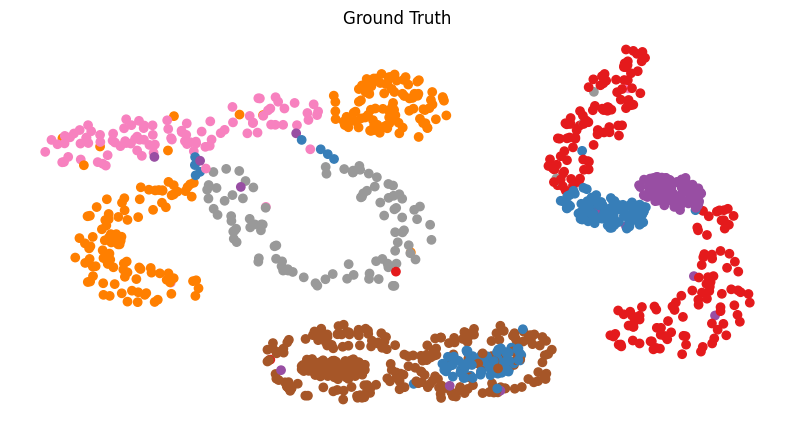

In [406]:
get_sticc_result(ground_truth, 'result-synthetic-data-ood-missglasso-localmean-0.30.txt', title='STICC')

# Global Mean Interpolation

In [356]:
!rm -rf result-synthetic-data-missing-globalmean-0.30.txt
!python STICC_main.py --fname=synthetic-data-missing-0.30.txt --oname=result-synthetic-data-missing-globalmean-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method global_mean

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 35)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({4: 259, 2: 199, 5: 166, 0: 155, 6: 152, 3: 142, 1: 140})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 155
length of the cluster  1 ------> 140
length of the cluster  2 ------> 199
length of the cluster  3 ------> 142
length of the cluster  4 ------> 259
length of the cluster  5 ------> 166
length of the cluster  6 ------> 152
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[67.5714 88.0159 102.0106 ... 65.9731 72.2056 66.2265]
 [54.5406 94.9053 114.6327 ... 60.9152 81.9641 67.6685]
 [48.8260 79.9474 93.6691 ... 60.0

ARI 0.7228972438969902
NMI 0.8037139049460157


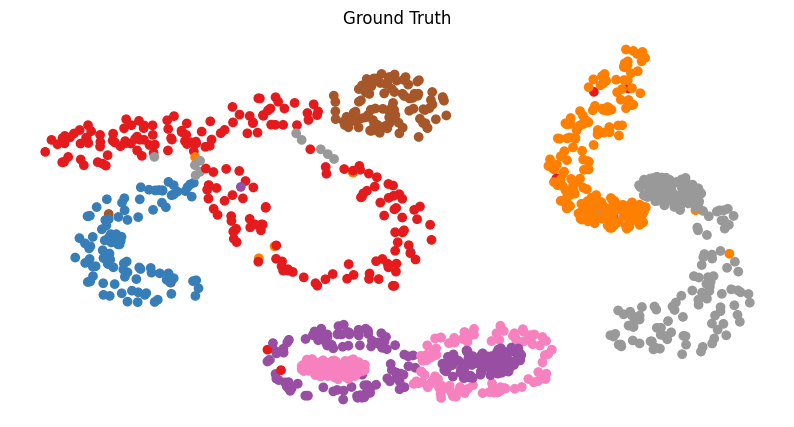

In [203]:
get_sticc_result(ground_truth, 'result-synthetic-data-missing-globalmean-0.30.txt', title='STICC')

# Local Mean Interpolation

In [66]:
!rm -rf result-synthetic-data-missing-localmean-0.30.txt
!python STICC_main.py --fname=synthetic-data-missing-0.30.txt --oname=result-synthetic-data-missing-localmean-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method local_mean --local_radius 3

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 256, 2: 209, 5: 188, 3: 175, 4: 155, 0: 140, 6: 90})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 140
length of the cluster  1 ------> 256
length of the cluster  2 ------> 209
length of the cluster  3 ------> 175
length of the cluster  4 ------> 155
length of the cluster  5 ------> 188
length of the cluster  6 ------> 90
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[102.5354 78.3821 77.6741 ... 79.0271 58.6077 149.6604]
 [113.9101 67.4408 78.8542 ... 73.7432 53.8809 146.6007]
 [88.7575 71.8183 73.5968 ... 62.3

ARI 0.8460646367538354


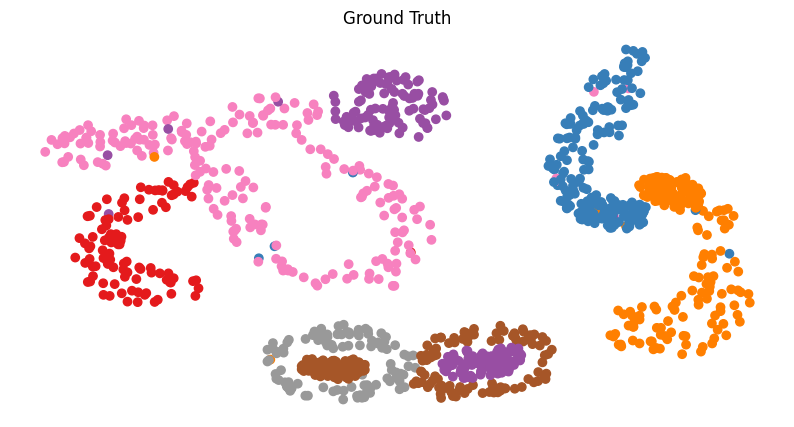

In [67]:
get_sticc_result(ground_truth, 'result-synthetic-data-missing-localmean-0.30.txt', title='STICC')

# Kriging Interpolation

In [15]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [62]:
!rm -rf result-synthetic-data-missing-kriging-0.30.txt
!python STICC_main.py --fname=synthetic-data-missing-0.30.txt --oname=result-synthetic-data-missing-kriging-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 --coord_idx_start=35 --coord_idx_end=36\
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method kriging

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({5: 233, 2: 215, 3: 203, 4: 196, 0: 167, 6: 130, 1: 69})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 167
length of the cluster  1 ------> 69
length of the cluster  2 ------> 215
length of the cluster  3 ------> 203
length of the cluster  4 ------> 196
l

ARI 0.8584685448951799


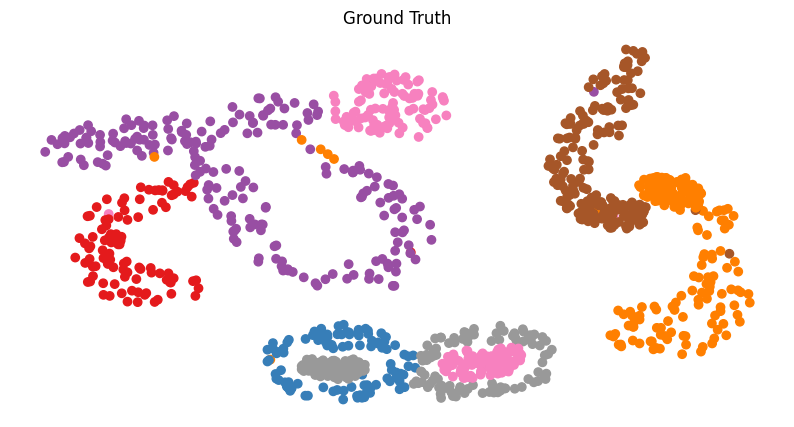

In [65]:
get_sticc_result(ground_truth, 'result-synthetic-data-missing-kriging-0.30.txt', title='STICC')

# Decision Tree Interpolation

In [70]:
from sklearn.tree import DecisionTreeRegressor

In [74]:
nidxs = np.isnan(missing_features)

In [88]:
tree_data = np.hstack((ground_truth[:,:2], clean_features))

In [89]:
X = tree_data[(~nidxs).all(axis=1),:5]
y = tree_data[(~nidxs).all(axis=1),5:]

In [90]:
X.shape

(420, 5)

In [91]:
X_test = tree_data[nidxs.any(axis=1),:5]
y_test = tree_data[nidxs.any(axis=1),5:]

In [92]:
X_test.shape

(793, 5)

In [93]:
regr = DecisionTreeRegressor(max_depth=8)
regr.fit(X, y)

DecisionTreeRegressor(max_depth=8)

In [94]:
y_pred = regr.predict(X_test)

In [95]:
X_test

array([[ 6.60000000e+02,  1.50600000e+04, -4.39238086e+00,
        -1.53497605e+00,  4.98691874e+00],
       [ 5.23000000e+03,  1.54100000e+04, -6.14244429e+00,
        -1.76270398e+00,  2.93027075e+00],
       [ 5.57000000e+03,  1.48200000e+04, -1.74206161e+00,
        -1.22501546e+00,  2.67016967e+00],
       ...,
       [ 1.05500000e+04,  1.44200000e+04, -3.75688749e+00,
        -1.41614017e+00,  4.26453910e+00],
       [ 1.08200000e+04,  1.41400000e+04, -4.02939076e+00,
         3.22611180e-01,  5.48380494e+00],
       [ 1.10600000e+04,  1.38600000e+04, -4.18303418e+00,
        -2.10300661e+00,  4.53449595e+00]])

In [96]:
y_pred

array([[-0.63282539, -4.39571837],
       [ 0.64879659, -3.85188247],
       [ 2.25217182, -3.60878875],
       ...,
       [-0.63282539, -4.39571837],
       [ 0.02636912, -2.89275105],
       [-0.35972821, -3.46626536]])

In [97]:
y_test

array([[-1.91712611, -2.86418744],
       [-0.93919641, -3.40119941],
       [ 1.43389386, -2.82816324],
       ...,
       [ 1.98821477, -2.49675282],
       [-1.39738532, -3.92965225],
       [ 1.39678855, -4.39978862]])

In [107]:
tree_data[:,np.array([1,0,0,1,1,0,0]).astype(bool)]

array([[ 6.60000000e+02, -1.53497605e+00,  4.98691874e+00],
       [ 4.93000000e+03, -1.88768591e+00,  4.88733762e+00],
       [ 5.23000000e+03, -1.76270398e+00,  2.93027075e+00],
       ...,
       [ 1.05500000e+04, -1.41614017e+00,  4.26453910e+00],
       [ 1.08200000e+04,  3.22611180e-01,  5.48380494e+00],
       [ 1.10600000e+04, -2.10300661e+00,  4.53449595e+00]])

In [105]:
tree_data[:,~np.array([True,False,False,True,True,False,False])]

array([[ 1.50600000e+04, -4.39238086e+00, -1.91712611e+00,
        -2.86418744e+00],
       [ 1.63300000e+04, -4.75774668e+00, -2.63266901e+00,
        -3.32773201e+00],
       [ 1.54100000e+04, -6.14244429e+00, -9.39196408e-01,
        -3.40119941e+00],
       ...,
       [ 1.44200000e+04, -3.75688749e+00,  1.98821477e+00,
        -2.49675282e+00],
       [ 1.41400000e+04, -4.02939076e+00, -1.39738532e+00,
        -3.92965225e+00],
       [ 1.38600000e+04, -4.18303418e+00,  1.39678855e+00,
        -4.39978862e+00]])

In [130]:
int(5/2)

2

In [155]:
!rm -rf result-synthetic-data-missing-tree-0.30.txt
!python STICC_main.py --fname=synthetic-data-missing-0.30.txt --oname=result-synthetic-data-missing-tree-0.30.txt --attr_idx_start=0 \
--attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 --coord_idx_start=35 --coord_idx_end=36\
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method tree --local_radius 3

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
Complete data:  (196, 5)
2.5
[[ True False False False False]
 [False  True False False False]
 [ True False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False  True False False]]
[[nan -1.5350 4.9869 -1.9171 -2.8642]
 [-4.7577 nan 4.8873 -2.6327 -3.3277]
 [nan -1.7627 2.9303 -0.9392 -3.4012]
 ...
 [-3.5678 -1.3724 4.2645 1.9882 -2.5208]
 [0.0000 0.0000 0.0000 -1.3974 -3.9297]
 [-4.1830 -2.1030 nan 1.3968 -4.3998]]




(0, 0, 0, 0, 1)
[False False False ... False False False]
(81, 5)
(81, 4)




(0, 0, 0, 1, 0)
[False False False ... False False False]
(97, 5)
(97, 4)




(0, 0, 0, 1, 1)
[False False False ... False False False]
(51, 5)
(51, 3)




(0, 0, 1, 0, 0)
[False False False ... False False  True]
(82, 5)
(82, 4)




(0, 0, 1, 0, 1)
[False False False ... False False False]
(33, 5)
(33, 3)




(0, 0, 1, 

OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 198
length of the cluster  1 ------> 195
length of the cluster  2 ------> 203
length of the cluster  3 ------> 201
length of the cluster  4 ------> 217
length of the cluster  5 ------> 100
length of the cluster  6 ------> 99
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[507.3164 119.1394 102.4804 ... 56.6508 946.8798 231.1557]
 [594.6854 88.9913 100.6212 ... 53.1818 979.8801 235.5926]
 [563.2852 94.7561 90.8980 ... 42.7693 941.4404 223.8613]
 ...
 [312.0193 100.2002 95.0438 ... 59.2632 632.9182 2137.3915]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 198
length of cluster # 1 --------> 195
length of cluster # 2 --------> 203
length of cluster # 3 --------> 201
length of

ARI 0.8504785033325968


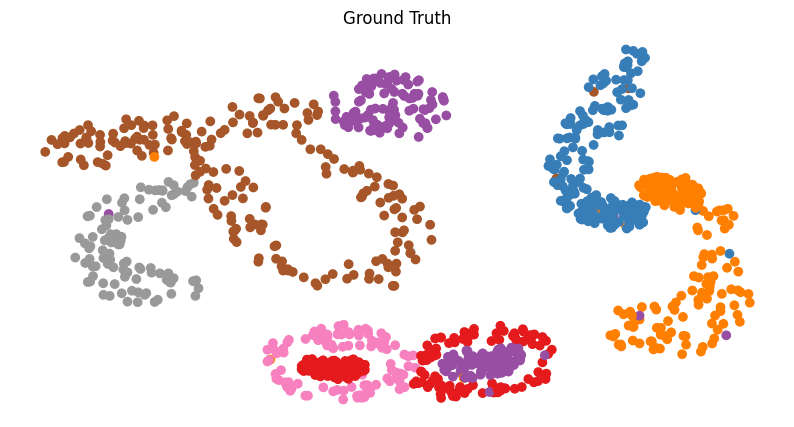

In [156]:
get_sticc_result(ground_truth, 'result-synthetic-data-missing-tree-0.30.txt', title='STICC')

# Batch Experiment

In [234]:
import os

In [210]:
import numpy as np, scipy.stats as st

In [437]:
for i in range(10):
    for r in np.arange(0.05,0.55,0.05):
        load_data(r, i)

0.04979389942291838
0.1055234954657873


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.15548227535037099
0.2047815333882935


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.25028854080791424
0.2941467436108821


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.34971145919208574
0.3975267930750206


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.44929925803792253
0.490684253915911


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.04732069249793899
0.09579554822753504


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.15119538334707336
0.19258037922506183


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.2611706512778236
0.3028854080791426


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.34080791426215995
0.4


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.4494641384995878
0.502555647155812


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.044682605111294314
0.09843363561417973


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.14591920857378401
0.20807914262159935


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.24633140972794723
0.29793899422918385


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.34987633965375103
0.3965375103050289


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.4458367683429514
0.5043693322341303


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.049299258037922504
0.09958779884583677


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.1553173948887057
0.19917559769167353


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.25045342126957953
0.2953009068425392


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.3596042868920033
0.3962077493816983


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.46875515251442706
0.5048639736191262


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.05638911788953009
0.10255564715581203


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.15366859027205276
0.19983511953833472


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.2595218466611707
0.30651277823577905


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.3612530915086562
0.3962077493816983


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.4458367683429514
0.4948062654575433


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.05012366034624897
0.09975267930750206


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.14674361088211046
0.20065952184666117


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.24847485572959604
0.29826875515251444


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.3520197856553998
0.39818631492168177


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.44847485572959606
0.49777411376751857


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.05012366034624897
0.09414674361088211


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.14723825226710635
0.20065952184666117


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.2443528441879637
0.29793899422918385


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.35169002473206923
0.38763396537510303


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.45935696619950533
0.49365210222588624


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.052267106347897774
0.09694971145919208


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.16125309150865622
0.19719703215169002


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.25556471558120364
0.3007419620774938


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.3446001648804617
0.39917559769167354


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.44929925803792253
0.49233305853256387


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.056718878812860675
0.10519373454245672


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.14641384995877987
0.1955482275350371


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.24781533388293486
0.302555647155812


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.35152514427040393
0.4021434460016488


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.45721352019785655
0.49084913437757627


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.051772464962901894
0.09612530915086562


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.14723825226710635
0.19373454245671887


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.25474031327287716
0.2971145919208574


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.3572959604286892
0.4


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.454080791426216
0.5043693322341303


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [266]:
def batch_experiment_clean_kmeans():
    aris, nmis = [], []
    for i in range(10):
        data = np.load("defective_data/synthetic-data-r-0.05-{:d}.npz".format(i))
        ground_truth = data["gt"]
        clean_features = data["clean"]
        kmeans = KMeans(n_clusters=7, n_init=300).fit(clean_features)
        ari, nmi = adjusted_rand_score(kmeans.labels_, ground_truth[:,2]), normalized_mutual_info_score(kmeans.labels_, ground_truth[:,2])
        aris.append(ari)
        nmis.append(nmi)
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi

In [253]:
def batch_experiment_clean_sticc():
    aris, nmis = [], []
    data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
    ground_truth = data["gt"]
    for i in range(10):
        os.system("""python STICC_main.py --fname=synthetic-data-clean-0.05-{}.txt --oname=result-synthetic-data-clean-glasso-0.05-{}.txt --attr_idx_start=0 \
        --attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
        --spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method glasso""".format(i, i))
        ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-clean-glasso-0.05-{}.txt".format(i))
        aris.append(ari)
        nmis.append(nmi)
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi

In [274]:
def batch_experiment_clean_stable_sticc(radius, rate):
    aris, nmis = [], []
    data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
    ground_truth = data["gt"]
    for i in range(10):
        os.system("""python STICC_main.py --fname=synthetic-data-clean-0.05-{}.txt --oname=result-synthetic-data-clean-missglasso-0.05-{}-{}-{}.txt --attr_idx_start=0 \
        --attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
        --spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso_random --local_radius {} --defect_rate {} --init_random""".format(i, i, radius, rate, radius, rate))
        ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-clean-missglasso-0.05-{}-{}-{}.txt".format(i, radius, rate))
        aris.append(ari)
        nmis.append(nmi)
        
        print("Finished batch {}".format(i))
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi

In [288]:
def batch_experiment_missing_sticc_global_mean(rate):
    aris, nmis = [], []
    data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
    ground_truth = data["gt"]
    nc = 0
    for i in range(10):
        try:
            os.system("""python STICC_main.py --fname=synthetic-data-missing-{}-{}.txt --oname=result-synthetic-data-missing-globalmean-{}-{}.txt --attr_idx_start=0 \
            --attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
            --spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method global_mean""".format(rate, i, rate, i))
            ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-missing-globalmean-{}-{}.txt".format(rate, i))
            aris.append(ari)
            nmis.append(nmi)
        except:
            nc += 1
        
        print("Finished batch {}".format(i))
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi, nc

In [292]:
def batch_experiment_missing_sticc_local_mean(rate):
    aris, nmis = [], []
    data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
    ground_truth = data["gt"]
    nc = 0
    for i in range(10):
        try:
            os.system("""python STICC_main.py --fname=synthetic-data-missing-{}-{}.txt --oname=result-synthetic-data-missing-globalmean-{}-{}.txt --attr_idx_start=0 \
            --attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
            --spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method local_mean --local_radius 3""".format(rate, i, rate, i))
            ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-missing-globalmean-{}-{}.txt".format(rate, i))
            aris.append(ari)
            nmis.append(nmi)
        except:
            nc += 1
        
        print("Finished batch {}".format(i))
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi, nc

In [345]:
def batch_experiment_missing_sticc_tree(rate):
    aris, nmis = [], []
    data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
    ground_truth = data["gt"]
    nc = 0
    for i in range(10):
        try:
            os.system("""python STICC_main.py --fname=synthetic-data-missing-{}-{}.txt --oname=result-synthetic-data-missing-tree-{}-{}-depth-5.txt --attr_idx_start=0 \
            --attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
            --spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method tree --local_radius 3""".format(rate, i, rate, i))
            ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-missing-tree-{}-{}-depth-5.txt".format(rate, i))
            aris.append(ari)
            nmis.append(nmi)
        except:
            nc += 1
        
        print("Finished batch {}".format(i))
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi, nc

In [310]:
def batch_experiment_missing_sticc_kriging(rate):
    aris, nmis = [], []
    data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
    ground_truth = data["gt"]
    nc = 0
    for i in range(10):
        try:
            os.system("""python STICC_main.py --fname=synthetic-data-missing-{}-{}.txt --oname=result-synthetic-data-missing-kriging-{}-{}.txt --attr_idx_start=0 \
            --attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
            --spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method kriging""".format(rate, i, rate, i))
            ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-missing-kriging-{}-{}.txt".format(rate, i))
            aris.append(ari)
            nmis.append(nmi)
        except:
            nc += 1
        
        print("Finished batch {}".format(i))
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi, nc

In [336]:
def batch_experiment_missing_stable_sticc(rate, radius):
    nc = 0
    for i in range(10):
        try:
            os.system("""python STICC_main.py --fname=synthetic-data-missing-{}-{}.txt --oname=result-synthetic-data-missing-missglasso-{}-{}-{}.txt --attr_idx_start=0 \
            --attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
            --spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso --local_radius {}""".format(rate, i, rate, i, radius, radius))
        except:
            nc += 1
        
        print("Finished batch {}".format(i))
    
    return nc

In [423]:
results_clean_kmeans = batch_experiment_clean_kmeans()

In [424]:
print("{:.4f} $\pm$ {:.4f}".format(results_clean_kmeans[2], results_clean_kmeans[4][1] - results_clean_kmeans[2]))
print("{:.4f} $\pm$ {:.4f}".format(results_clean_kmeans[3], results_clean_kmeans[5][1] - results_clean_kmeans[3]))

0.9252 $\pm$ 0.0484
0.9284 $\pm$ 0.0367


In [254]:
results_clean_sticc = batch_experiment_clean_sticc()

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({5: 213, 1: 210, 2: 199, 4: 194, 6: 193, 3: 104, 0: 100})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 100
length of the cluster  1 ------> 210
length of the cluster  2 ------> 199
length of the cluster  3 ------> 104
length of the cluster  4 ------> 194
length of the cluster  5 ------> 213
length of the cluster  6 ------> 193
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[2195.1860 90.4429 163.4239 ... 341.3958 44.0218 381.8608]
 [2428.9426 67.8194 124.5296 ... 227.3476 46.1915 248.1718]
 [2336.1805 120.5953 204.5

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({2: 215, 3: 206, 1: 198, 4: 198, 0: 194, 6: 101, 5: 101})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 194
length of the cluster  1 ------> 198
length of the cluster  2 ------> 215
length of the cluster  3 ------> 206
length of the cluster  4 ------> 198
length of the cluster  5 ------> 101
length of the cluster  6 ------> 101
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[130.0628 346.0707 41.5356 ... 309.9188 333.7172 423.5972]
 [154.2999 344.8685 45.3226 ... 313.0558 356.4201 436.3104]
 [137.2393 330.1073 42.906

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({5: 220, 0: 205, 6: 200, 3: 199, 4: 197, 1: 103, 2: 89})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 205
length of the cluster  1 ------> 103
length of the cluster  2 ------> 89
length of the cluster  3 ------> 199
length of the cluster  4 ------> 197
length of the cluster  5 ------> 220
length of the cluster  6 ------> 200
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[128.7829 286.6532 108.1910 ... 423.5962 39.5806 192.4033]
 [143.6313 348.8273 121.0678 ... 529.1772 43.7168 246.5604]
 [195.1015 329.8335 134.9985

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({0: 215, 6: 202, 3: 201, 2: 200, 4: 197, 5: 103, 1: 95})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 215
length of the cluster  1 ------> 95
length of the cluster  2 ------> 200
length of the cluster  3 ------> 201
length of the cluster  4 ------> 197
length of the cluster  5 ------> 103
length of the cluster  6 ------> 202
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[45.6407 875.1854 112.2649 ... 326.1451 249.7528 141.9554]
 [46.7818 889.8635 132.5835 ... 257.7410 254.2885 148.5392]
 [48.1812 822.2042 120.3996 

In [260]:
print("{:.4f} $\pm$ {:.4f}".format(results_clean_sticc[2], results_clean_sticc[4][1] - results_clean_sticc[2]))
print("{:.4f} $\pm$ {:.4f}".format(results_clean_sticc[3], results_clean_sticc[5][1] - results_clean_sticc[3]))

0.9646 $\pm$ 0.0019
0.9558 $\pm$ 0.0021


In [275]:
results_clean_stable_sticc_10_005 = batch_experiment_clean_stable_sticc(radius=10, rate=0.05)

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({0: 218, 3: 209, 4: 203, 1: 192, 5: 184, 2: 112, 6: 95})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 218
length of the cluster  1 ------> 192
length of the cluster  2 ------> 112
length of the cluster  3 ------> 209
length of the cluster  4 ------> 203
length 

Finished batch 1
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({4: 215, 2: 207, 3: 199, 0: 199, 5: 174, 1: 119, 6: 100})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 199
length of the cluster  1 ------> 119
length of the cluster  2 ------> 207
length of the cluster  3 ------> 199
length of the cluster  4 -

/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -1.186e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -3.055e-04
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -2.769e-04
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -2.167e-04
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_grap




ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 202
length of the cluster  1 ------> 219
length of the cluster  2 ------> 192
length of the cluster  3 ------> 99
length of the cluster  4 ------> 195
length of the cluster  5 ------> 199
length of the cluster  6 ------> 107
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[311.6519 42.0207 355.2138 ... 125.3313 307.2107 407.7774]
 [316.6928 46.2230 350.6802 ... 152.2886 311.367

Finished batch 4
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({4: 215, 1: 204, 0: 202, 6: 199, 2: 198, 5: 99, 3: 96})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 202
length of the cluster  1 ------> 204
length of the cluster  2 ------> 198
length of the cluster  3 ------> 96
length of the cluster  4 ----

Finished batch 6
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({4: 226, 6: 210, 3: 202, 5: 194, 1: 188, 2: 98, 0: 95})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 95
length of the cluster  1 ------> 188
length of the cluster  2 ------> 98
length of the cluster  3 ------> 202
length of the cluster  4 -----

length of cluster # 3 --------> 200
length of cluster # 4 --------> 199
length of cluster # 5 --------> 102
length of cluster # 6 --------> 203







ITERATION ### 11
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 197
length of the cluster  1 ------> 214
length of the cluster  2 ------> 98
length of the cluster  3 ------> 200
length of the cluster  4 ------> 199
length of the cluster  5 ------> 102
length of the cluster  6 ------> 203
UPDATED THE OLD COVARI

Finished batch 8
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({4: 216, 6: 206, 5: 201, 3: 194, 0: 192, 2: 107, 1: 97})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 192
length of the cluster  1 ------> 97
length of the cluster  2 ------> 107
length of the cluster  3 ------> 194
length of the cluster  4 ---

In [276]:
aris, nmis, mari, mnmi, confari, confnmi = results_clean_stable_sticc_10_005

print("{:.4f} $\pm$ {:.4f}".format(mari, confari[1] - mari))
print("{:.4f} $\pm$ {:.4f}".format(mnmi, confnmi[1] - mnmi))

0.9629 $\pm$ 0.0062
0.9547 $\pm$ 0.0053


In [263]:
print("{:.4f} $\pm$ {:.4f}".format(results_clean_stable_sticc[2], results_clean_stable_sticc[4][1] - results_clean_stable_sticc[2]))
print("{:.4f} $\pm$ {:.4f}".format(results_clean_stable_sticc[3], results_clean_stable_sticc[5][1] - results_clean_stable_sticc[3]))

0.9646 $\pm$ 0.0019
0.9558 $\pm$ 0.0021


In [272]:
results_clean_stable_sticc_10_01 = batch_experiment_clean_stable_sticc(radius=10, rate=0.1)

Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9


In [273]:
aris, nmis, mari, mnmi, confari, confnmi = results_clean_stable_sticc_10_01

print("{:.4f} $\pm$ {:.4f}".format(mari, confari[1] - mari))
print("{:.4f} $\pm$ {:.4f}".format(mnmi, confnmi[1] - mnmi))

0.9641 $\pm$ 0.0023
0.9553 $\pm$ 0.0025


In [277]:
results_clean_stable_sticc_10_02 = batch_experiment_clean_stable_sticc(radius=10, rate=0.2)

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({3: 218, 4: 217, 1: 206, 2: 203, 6: 161, 0: 118, 5: 90})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 118
length of the cluster  1 ------> 206
length of the cluster  2 ------> 203
length of the cluster  3 ------> 218
length of the cluster  4 ------> 217
length 

/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.805e-02
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.834e-02
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.981e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.519e-02
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_la




ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 115
length of the cluster  1 ------> 210
length of the cluster  2 ------> 208
length of the cluster  3 ------> 174
length of the cluster  4 ------> 197
length of the cluster  5 ------> 175
length of the cluster  6 ------> 134
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[66.4692 73.4400 41.1424 ... 103.1064 283.0189 605.4187]
 [68.3917 70.5328 41.0682 ... 105.5255 387.6423 6

length of cluster # 6 --------> 200







ITERATION ### 11
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 98
length of the cluster  1 ------> 100
length of the cluster  2 ------> 216
length of the cluster  3 ------> 200
length of the cluster  4 ------> 198
length of the cluster  5 ------> 201
length of the cluster  6 ------> 200
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[361.0228 152.4681 42.2302 ... 102.4180 105.3062 809.1098]
 [390.8

Finished batch 1
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({0: 215, 4: 197, 3: 196, 2: 193, 1: 161, 6: 141, 5: 110})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 215
length of the cluster  1 ------> 161
length of the cluster  2 ------> 193
length of the cluster  3 ------> 196
length of the cluster  4 -

Finished batch 2
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({0: 219, 2: 216, 1: 215, 3: 187, 4: 168, 5: 113, 6: 95})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 219
length of the cluster  1 ------> 215
length of the cluster  2 ------> 216
length of the cluster  3 ------> 187
length of the cluster  4 --

Finished batch 4
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({3: 223, 1: 210, 4: 209, 5: 192, 0: 186, 6: 106, 2: 87})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 186
length of the cluster  1 ------> 210
length of the cluster  2 ------> 87
length of the cluster  3 ------> 223
length of the cluster  4 ---

Finished batch 5
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({3: 232, 4: 209, 2: 184, 0: 180, 6: 167, 1: 167, 5: 74})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 180
length of the cluster  1 ------> 167
length of the cluster  2 ------> 184
length of the cluster  3 ------> 232
length of the cluster  4 --

Finished batch 7
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({1: 321, 3: 208, 2: 208, 4: 168, 5: 121, 6: 97, 0: 90})


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 4.517e-04
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.616e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 1.760e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -1.374e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_l

/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -2.976e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -2.996e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -3.003e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -2.933e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_grap




ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 90
length of the cluster  1 ------> 321
length of the cluster  2 ------> 208
length of the cluster  3 ------> 208
length of the cluster  4 ------> 168
length of the cluster  5 ------> 121
length of the cluster  6 ------> 97
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[277.2926 251.5488 118.6392 ... 107.4476 66.9238 1535.0788]
 [286.6403 243.8405 95.8447 ... 88.5485 53.0311 

Finished batch 8
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({2: 200, 5: 198, 3: 190, 0: 184, 1: 172, 4: 136, 6: 133})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 184
length of the cluster  1 ------> 172
length of the cluster  2 ------> 200
length of the cluster  3 ------> 190
length of the cluster  4 -

Finished batch 9


In [278]:
aris, nmis, mari, mnmi, confari, confnmi = results_clean_stable_sticc_10_02

print("{:.4f} $\pm$ {:.4f}".format(mari, confari[1] - mari))
print("{:.4f} $\pm$ {:.4f}".format(mnmi, confnmi[1] - mnmi))

0.9279 $\pm$ 0.0419
0.9365 $\pm$ 0.0216


In [289]:
results_missing_sticc_globalmean_030 = batch_experiment_missing_sticc_global_mean("0.30")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({3: 242, 1: 221, 0: 202, 2: 168, 5: 151, 6: 146, 4: 83})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 202
length of the cluster  1 ------> 221
length of the cluster  2 ------> 168
length of the cluster  3 ------> 242
length of the cluster  4 ------> 83
length of the cluster  5 ------> 151
length of the cluster  6 ------> 146
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[63.2856 137.6539 130.7751 ... 158.0978 51.0988 118.0204]
 [56.1800 101.4227 88.9950 ... 142.0091 52.8794 91.1755]
 [66.1083 133.2117 183.6467 ... 

Finished batch 0
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({4: 214, 2: 205, 6: 204, 0: 164, 1: 157, 3: 143, 5: 126})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 164
length of the cluster  1 ------> 157
length of the cluster  2 ------> 205
length of the cluster  3 ------> 143
length of the cluster  4 ------> 214
length of the cluster  5 ------> 126
length of the cluster  6 ------> 204
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[66.1064 49.5157 59.3256 ... 68.8997 256.7822 50.4087]
 [68.9540 46.4460 58.9288 ... 76.7344 307.7191 50.7438]
 [78.3882 53.5210

Finished batch 1
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 277, 0: 212, 4: 173, 3: 166, 5: 163, 6: 150, 2: 72})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 212
length of the cluster  1 ------> 277
length of the cluster  2 ------> 72
length of the cluster  3 ------> 166
length of the cluster  4 ------> 173
length of the cluster  5 ------> 163
length of the cluster  6 ------> 150
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[64.7645 62.1303 77.4969 ... 111.9935 54.6628 87.6260]
 [61.6313 54.3263 73.3698 ... 99.6058 61.0745 73.2943]
 [81.7518 81.3387 84

Finished batch 3
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({4: 359, 6: 171, 3: 154, 2: 149, 1: 143, 0: 143, 5: 94})


/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py:1631: RuntimeWarning: Degrees of freedom <= 0 for slice
  S = np.cov(np.transpose(D_train), bias=self.biased)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)





ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 143
length of the cluster  1 ------> 143
length of the cluster  2 ------> 149
length of the cluster  3 ------> 154
length of the cluster  4 ------> 359
length of the cluster  5 ------> 94
length of the cluster  6 ------> 171
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[127.8265 49.5429 139.7264 ... 65.1060 48.8966 94.7400]
 [77.5273 60.0574 74.3917 ... 54.1682 58.6910 69.1805]
 [108.9752 58.3424 117.1070 ... 72.7338 54.8846 86.7694]
 ...
 [101.8735 54.5988 94.2941 ... 61.4613 57.6641 75.5429]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 198
length of cluster # 1 --------> 181


multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/Users/octopolugal/Desktop/Research/MissSTICC/src/admm_solver.py", line 114, in __call__
    self.ADMM_x()
  File "/Users/octopolugal/Desktop/Research/MissSTICC/src/admm_solver.py", line 40, in ADMM_x
    x_update = self.Prox_logdet(self.S, A, eta)
  File "/Users/octopolugal/Desktop/Research/MissSTICC/src/admm_solver.py", line 30, in Prox_logdet
    d, q = numpy.linalg.eigh(eta*A-S)
  File "<__array_function__ internals>", line 180, in eigh
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 1458, in eigh
    w, vt = gufunc(a, signature=signature, extobj=extobj)
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 94, in _raise_linalgerro

Finished batch 4
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({2: 246, 3: 199, 1: 173, 5: 162, 4: 157, 6: 150, 0: 126})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 126
length of the cluster  1 ------> 173
length of the cluster  2 ------> 246
length of the cluster  3 ------> 199
length of the cluster  4 ------> 157
length of the cluster  5 ------> 162
length of the cluster  6 ------> 150
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[57.3745 188.4829 67.4656 ... 162.0036 124.6449 98.3371]
 [70.8311 150.5788 86.1523 ... 162.8364 151.3112 121.3960]
 [62.9392 10

Finished batch 5
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 214, 3: 213, 5: 212, 4: 195, 0: 171, 2: 123, 6: 85})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 171
length of the cluster  1 ------> 214
length of the cluster  2 ------> 123
length of the cluster  3 ------> 213
length of the cluster  4 ------> 195
length of the cluster  5 ------> 212
length of the cluster  6 ------> 85
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[53.9255 47.5354 78.5766 ... 64.2645 48.4670 56.2326]
 [62.3420 52.3431 142.4816 ... 84.8096 47.5777 68.9804]
 [69.5194 62.3569 20

Finished batch 6
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({2: 220, 5: 216, 4: 215, 0: 196, 1: 156, 3: 130, 6: 80})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 196
length of the cluster  1 ------> 156
length of the cluster  2 ------> 220
length of the cluster  3 ------> 130
length of the cluster  4 ------> 215
length of the cluster  5 ------> 216
length of the cluster  6 ------> 80
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[74.3579 79.4944 78.2712 ... 45.9495 57.7070 226.1827]
 [74.4482 76.6668 70.5350 ... 51.2011 59.6974 234.0548]
 [77.6868 91.6198 7

Finished batch 7
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({0: 282, 3: 265, 4: 160, 2: 141, 1: 137, 6: 136, 5: 92})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 282
length of the cluster  1 ------> 137
length of the cluster  2 ------> 141
length of the cluster  3 ------> 265
length of the cluster  4 ------> 160
length of the cluster  5 ------> 92
length of the cluster  6 ------> 136
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[164.8198 57.8080 100.3887 ... 203.0091 79.8995 77.5053]
 [131.0927 55.0209 92.2983 ... 194.3664 64.8021 53.8230]
 [152.0751 49.70

Finished batch 8
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 219, 3: 205, 6: 180, 5: 174, 4: 168, 2: 138, 0: 129})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 129
length of the cluster  1 ------> 219
length of the cluster  2 ------> 138
length of the cluster  3 ------> 205
length of the cluster  4 ------> 168
length of the cluster  5 ------> 174
length of the cluster  6 ------> 180
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[59.3830 47.5624 66.5196 ... 46.9904 70.5073 54.1949]
 [56.9689 49.0498 60.9718 ... 47.2332 71.1853 64.0518]
 [63.8809 50.9952 6

Finished batch 9


In [283]:
aris, nmis, mari, mnmi, confari, confnmi = results_clean_stable_sticc_globalmean_005

print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

96.14 $\pm$ 0.54
95.35 $\pm$ 0.43


In [286]:
aris, nmis, mari, mnmi, confari, confnmi = results_missing_sticc_globalmean_010

print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

93.71 $\pm$ 5.32
94.32 $\pm$ 2.09


In [290]:
aris, nmis, mari, mnmi, confari, confnmi, nc = results_missing_sticc_globalmean_030

print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

80.27 $\pm$ 6.84
86.27 $\pm$ 3.43


In [293]:
results_missing_sticc_localmean_005 = batch_experiment_missing_sticc_local_mean("0.05")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({3: 213, 0: 212, 1: 200, 4: 199, 6: 162, 5: 127, 2: 100})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 212
length of the cluster  1 ------> 200
length of the cluster  2 ------> 100
length of the cluster  3 ------> 213
length of the cluster  4 ------> 199
length of the cluster  5 ------> 127
length of the cluster  6 ------> 162
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[89.2509 466.1120 2164.5897 ... 151.1346 129.6264 423.2066]
 [67.6308 308.2342 2360.7049 ... 121.5095 99.6633 303.5849]
 [116.2547 617.2118 2333.

Finished batch 2
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({0: 215, 3: 207, 1: 197, 5: 193, 6: 192, 2: 107, 4: 102})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 215
length of the cluster  1 ------> 197
length of the cluster  2 ------> 107
length of the cluster  3 ------> 207
length of the cluster  4 ------> 102
length of the cluster  5 ------> 193
length of the cluster  6 ------> 192
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[41.6212 348.0159 427.3548 ... 304.2319 119.0959 361.4159]
 [44.1565 349.3608 438.7141 ... 324.4422 140.4206 361.5090]
 [42.3822

Finished batch 5
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({5: 220, 2: 208, 3: 199, 0: 199, 1: 198, 6: 102, 4: 87})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 199
length of the cluster  1 ------> 198
length of the cluster  2 ------> 208
length of the cluster  3 ------> 199
length of the cluster  4 ------> 87
length of the cluster  5 ------> 220
length of the cluster  6 ------> 102
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[75.2943 194.5590 125.7661 ... 121.7878 39.5038 267.5637]
 [86.4388 242.2830 139.0637 ... 146.0917 43.5358 323.4267]
 [90.6468 284

Finished batch 7
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({0: 217, 1: 214, 2: 200, 4: 198, 5: 184, 6: 100, 3: 100})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 217
length of the cluster  1 ------> 214
length of the cluster  2 ------> 200
length of the cluster  3 ------> 100
length of the cluster  4 ------> 198
length of the cluster  5 ------> 184
length of the cluster  6 ------> 100
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[230.2272 52.1588 261.3322 ... 109.7286 234.5885 1452.4186]
 [286.0627 41.0948 282.5476 ... 130.2952 242.8111 1389.0721]
 [358.5

Finished batch 9


In [294]:
aris, nmis, mari, mnmi, confari, confnmi, nc = results_missing_sticc_localmean_005

print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))
print(nc)

96.55 $\pm$ 0.18
95.67 $\pm$ 0.22
0


In [309]:
rate = "0.30"

aris, nmis = [], []
data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
ground_truth = data["gt"]

for i in range(10):
    ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-missing-localmean-{}-{}.txt".format(rate, i))
    aris.append(ari)
    nmis.append(nmi)
    
mari = np.mean(aris)
mnmi = np.mean(nmis)
confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

88.75 $\pm$ 4.71
90.88 $\pm$ 2.44


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [346]:
results_missing_sticc_tree_030_depth_5 = batch_experiment_missing_sticc_tree("0.30")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
Complete data:  (207, 5)
2.5
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({4: 278, 6: 218, 0: 208, 1: 181, 5: 177, 3: 84, 2: 67})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 208
length of the cluster  1 ------> 181
length of the cluster  2 ------> 67
length of the cluster  3 ------> 84
length of the cluster  4 ------> 278
length of the cluster  5 ------> 177
length of the cluster  6 ------> 218
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[42.2527 105.9394 61.8932 ... 118.9974 158.5580 62.8658]
 [45.5148 85.9834 63.1445 ... 98.8569 133.7798 60.7773]
 [50.19

Finished batch 1
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
Complete data:  (200, 5)
2.5
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({5: 227, 1: 210, 2: 194, 6: 170, 3: 165, 4: 149, 0: 98})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 98
length of the cluster  1 ------> 210
length of the cluster  2 ------> 194
length of the cluster  3 ------> 165
length of the cluster  4 ------> 149
length of the cluster  5 ------> 227
length of the cluster  6 ------> 170
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[68.4004 116.2625 129.3866 ... 76.6100 45.8852 107.2566]
 [65.3465 98.0779 102.7465 ... 66.8734 48.70

Finished batch 3
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
Complete data:  (194, 5)
2.5
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({5: 228, 6: 208, 3: 198, 2: 185, 4: 183, 1: 118, 0: 93})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 93
length of the cluster  1 ------> 118
length of the cluster  2 ------> 185
length of the cluster  3 ------> 198
length of the cluster  4 ------> 183
length of the cluster  5 ------> 228
length of the cluster  6 ------> 208
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[72.4047 63.9999 125.1460 ... 77.9504 91.4710 51.5969]
 [70.7414 60.6498 123.6866 ... 71.4772 90.2798

Finished batch 5
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
Complete data:  (208, 5)
2.5
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({5: 252, 4: 235, 2: 186, 1: 186, 6: 170, 3: 100, 0: 84})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 84
length of the cluster  1 ------> 186
length of the cluster  2 ------> 186
length of the cluster  3 ------> 100
length of the cluster  4 ------> 235
length of the cluster  5 ------> 252
length of the cluster  6 ------> 170
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[72.1655 78.3154 57.1198 ... 50.4242 46.9380 75.7243]
 [78.2443 84.0956 59.1078 ... 52.2507 45.8987 9

Finished batch 6
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
Complete data:  (221, 5)
2.5
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({3: 251, 4: 214, 0: 193, 1: 174, 6: 171, 5: 116, 2: 94})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 193
length of the cluster  1 ------> 174
length of the cluster  2 ------> 94
length of the cluster  3 ------> 251
length of the cluster  4 ------> 214
length of the cluster  5 ------> 116
length of the cluster  6 ------> 171
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[110.6552 117.9113 263.1962 ... 71.5755 65.2556 61.1351]
 [118.8380 123.2719 276.4867 ... 76.9166 66.

Finished batch 8
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
Complete data:  (213, 5)
2.5
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({2: 238, 3: 207, 6: 198, 4: 194, 0: 177, 1: 104, 5: 95})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 177
length of the cluster  1 ------> 104
length of the cluster  2 ------> 238
length of the cluster  3 ------> 207
length of the cluster  4 ------> 194
length of the cluster  5 ------> 95
length of the cluster  6 ------> 198
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[127.3220 123.2234 72.9532 ... 115.5958 116.3600 82.7297]
 [58.1631 105.5930 47.1237 ... 84.0685 73.6

Finished batch 9


In [347]:
aris, nmis, mari, mnmi, confari, confnmi, nc = results_missing_sticc_tree_030_depth_5

print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))
print(nc)

88.50 $\pm$ 6.22
90.69 $\pm$ 3.35
0


In [297]:
aris, nmis, mari, mnmi, confari, confnmi, nc = results_missing_sticc_tree_005

print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))
print(nc)

96.38 $\pm$ 0.23
95.48 $\pm$ 0.29
0


In [299]:
aris, nmis, mari, mnmi, confari, confnmi, nc = results_missing_sticc_tree_010

print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))
print(nc)

95.88 $\pm$ 0.49
95.01 $\pm$ 0.45
0


In [328]:
aris, nmis, mari, mnmi, confari, confnmi, nc = results_missing_sticc_tree_030

print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))
print(nc)

91.89 $\pm$ 5.22
92.57 $\pm$ 2.19
0


In [329]:
aris

[0.9393839521639407,
 0.8891235990632819,
 0.9601949197256107,
 0.9485859008745027,
 0.9494810205445021,
 0.9502557438046737,
 0.9352221463500014,
 0.9579160055482231,
 0.7193183620612167,
 0.9392619987832969]

In [311]:
results_missing_sticc_kriging_030 = batch_experiment_missing_sticc_kriging("0.30")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({2: 287, 4: 211, 1: 210, 3: 198, 5: 122, 0: 99, 6: 86})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 99
length of the cluster  1 ------> 210
length of the cluster  2 ------> 287
length of the cluster  3 ------> 198
length of the cluster  4 ------> 211
le




ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 197
length of the cluster  1 ------> 345
length of the cluster  2 ------> 132
length of the cluster  3 ------> 148
length of the cluster  4 ------> 115
length of the cluster  5 ------> 126
length of the cluster  6 ------> 150
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[131.8549 75.9861 91.0582 ... 49.6568 868.0483 89.3477]
 [162.6239 71.8050 94.1625 ... 43.8610 1021.1422 86.1819]
 [169.1920 95.4125 109.3740 ... 50.1665 1001.4026 108.1340]
 ...
 [147.4456 103.0730 79.9307 ... 61.3604 483.6385 72.8907]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 202
length of cluster # 1 -----

Finished batch 1
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({3: 262, 5: 215, 4: 174, 0: 169, 1: 160, 6: 135, 2: 98})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 169
length of the cluster  1 ------> 160
length of the cluster  2 ------> 98
length of the cluster  3 ------> 262
length of the cluster

Finished batch 3
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({0: 214, 5: 211, 3: 202, 2: 197, 4: 186, 1: 106, 6: 97})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 214
length of the cluster  1 ------> 106
length of the cluster  2 ------> 197
length of the cluster  3 ------> 202
length of the cluste

Finished batch 5
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 371, 4: 192, 5: 152, 0: 151, 3: 135, 6: 110, 2: 102})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 151
length of the cluster  1 ------> 371
length of the cluster  2 ------> 102
length of the cluster  3 ------> 135
length of the clust

Finished batch 6
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 273, 3: 227, 5: 210, 4: 146, 6: 138, 0: 132, 2: 87})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 132
length of the cluster  1 ------> 273
length of the cluster  2 ------> 87
length of the cluster  3 ------> 227
length of the cluster

Finished batch 7
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({6: 267, 5: 197, 3: 193, 2: 184, 1: 172, 0: 111, 4: 89})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 111
length of the cluster  1 ------> 172
length of the cluster  2 ------> 184
length of the cluster  3 ------> 193
length of the cluste

Finished batch 8
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({4: 208, 3: 200, 6: 180, 2: 171, 1: 163, 5: 154, 0: 137})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 137
length of the cluster  1 ------> 163
length of the cluster  2 ------> 171
length of the cluster  3 ------> 200
length of the clust

In [348]:
results_missing_sticc_kriging_030_mean = batch_experiment_missing_sticc_kriging("0.30")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({0: 288, 1: 224, 5: 206, 4: 194, 2: 122, 3: 92, 6: 87})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 288
length of the cluster  1 ------> 224
length of the cluster  2 ------> 122
length of the cluster  3 ------> 92
length of the cluster  4 ------> 194
le

Finished batch 1
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 269, 3: 213, 2: 177, 5: 161, 0: 160, 4: 134, 6: 99})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 160
length of the cluster  1 ------> 269
length of the cluster  2 ------> 177
length of the cluster  3 ------> 213
length of the cluste

Finished batch 3
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({4: 213, 2: 211, 0: 202, 3: 200, 1: 187, 6: 103, 5: 97})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 202
length of the cluster  1 ------> 187
length of the cluster  2 ------> 211
length of the cluster  3 ------> 200
length of the cluste

Finished batch 5
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 373, 3: 188, 5: 151, 6: 149, 4: 136, 0: 111, 2: 105})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 111
length of the cluster  1 ------> 373
length of the cluster  2 ------> 105
length of the cluster  3 ------> 188
length of the clust




ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 225
length of the cluster  1 ------> 146
length of the cluster  2 ------> 134
length of the cluster  3 ------> 86
length of the cluster  4 ------> 214
length of the cluster  5 ------> 139
length of the cluster  6 ------> 269
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[79.9888 88.5459 58.4950 ... 45.8527 77.9639 77.1970]
 [76.2564 85.7364 62.9287 ... 51.3006 113.5192 71.7449]
 [81.9105 104.1500 55.0695 ... 43.3984 91.3297 74.3235]
 ...
 [60.0114 103.8962 63.7112 ... 72.7277 125.1261 66.8394]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 264
length of cluster # 1 --------> 183
l

Finished batch 7
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
(1213,) (1213,)
[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]
(1213, 35)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({2: 395, 5: 211, 0: 206, 4: 131, 1: 123, 3: 77, 6: 70})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 206
length of the cluster  1 ------> 123
length of the cluster  2 ------> 395
length of the cluster  3 ------> 77
length of the cluster 




ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 158
length of the cluster  1 ------> 200
length of the cluster  2 ------> 157
length of the cluster  3 ------> 220
length of the cluster  4 ------> 171
length of the cluster  5 ------> 168
length of the cluster  6 ------> 139
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[73.2374 70.2792 89.3461 ... 90.7406 68.4317 64.7048]
 [73.8083 69.7098 89.6419 ... 100.1836 72.6596 65.2523]
 [87.5929 65.4168 106.6880 ... 114.0107 79.5755 87.9807]
 ...
 [67.2512 107.8292 84.7967 ... 120.1355 106.2952 123.2176]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 180
length of cluster # 1 --------> 2

Finished batch 9


In [349]:
aris, nmis, mari, mnmi, confari, confnmi, nc = results_missing_sticc_kriging_030_mean

print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))
print(nc)

85.59 $\pm$ 5.72
89.63 $\pm$ 2.67
0


In [312]:
aris, nmis, mari, mnmi, confari, confnmi, nc = results_missing_sticc_kriging_030

print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))
print(nc)

84.95 $\pm$ 5.75
89.10 $\pm$ 3.00
0


In [326]:
rate = "0.30"

aris, nmis = [], []
data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
ground_truth = data["gt"]

for i in range(10):
    ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-missing-kriging-{}-{}.txt".format(rate, i))
    aris.append(ari)
    nmis.append(nmi)
    
mari = np.mean(aris)
mnmi = np.mean(nmis)
confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

84.95 $\pm$ 5.75
89.10 $\pm$ 3.00


In [327]:
aris

[0.8016827750094346,
 0.7188421306052735,
 0.9405274209103363,
 0.865311037716099,
 0.9601415809258568,
 0.9559207952420194,
 0.8154390970186102,
 0.7916543928354783,
 0.8036621814942817,
 0.841410453198694]

In [337]:
nc = batch_experiment_missing_stable_sticc("0.30", "5")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Start fitting MissGLasso Model
(1213, 5)
Counter({3: 261, 0: 229, 6: 207, 1: 192, 4: 138, 2: 110, 5: 76})


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -5.525e-02
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -1.213e-01
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -2.176e-01
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -3.400e-01
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_grap




ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 229
length of the cluster  1 ------> 192
length of the cluster  2 ------> 110
length of the cluster  3 ------> 261
length of the cluster  4 ------> 138
length of the cluster  5 ------> 76
length of the cluster  6 ------> 207
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[60.9994 117.1295 68.2822 ... 144.9528 1989.4075 42.1749]
 [54.9008 96.8099 65.1927 ... 121.5688 2142.3461 

Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 74, in <module>
    main()
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 48, in main
    (cluster_assignment, cluster_MRFs) = sticc.fit_missglasso(input_file=args.fname, radius=args.local_radius)
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1114, in fit_missglasso
    self.optimize_clusters(computed_covariance, len_train_clusters, log_det_values, opt_res,
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1591, in optimize_clusters
    val = optRes[cluster].get()
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/pool.py", line 765, in get
    self.wait(timeout)
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/pool.py", line 762, in wait
    self._event.wait(timeout)
  File "/Users/octopolugal/anaconda3




ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 205
length of the cluster  1 ------> 147
length of the cluster  2 ------> 132
length of the cluster  3 ------> 173
length of the cluster  4 ------> 191
length of the cluster  5 ------> 181
length of the cluster  6 ------> 184
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[79.0318 70.5543 354.9426 ... 59.8288 90.0993 101.3889]
 [57.3898 80.4412 422.3974 ... 43.7936 84.5202 179

Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 74, in <module>
    main()
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 48, in main
    (cluster_assignment, cluster_MRFs) = sticc.fit_missglasso(input_file=args.fname, radius=args.local_radius)
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1114, in fit_missglasso
    self.optimize_clusters(computed_covariance, len_train_clusters, log_det_values, opt_res,
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1591, in optimize_clusters
Traceback (most recent call last):
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/User




ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
Finished batch 2
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Start fitting MissGLasso Model
(1213, 5)
Counter({4: 240, 0: 200, 6: 189, 3: 189, 5: 183, 1: 108, 2: 104})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213


Traceback (most recent call last):
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 74, in <module>
    main()
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 48, in main
    (cluster_assignment, cluster_MRFs) = sticc.fit_missglasso(input_file=args.fname, radius=args.local_radius)
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1114, in fit_missglasso
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    self.optimize_clusters(computed_covariance, len_train_clusters, log_det_values, opt_res,
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1591, in optimize_clusters
    val = optRes[cluster].get()
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/pool.py", line 765, in get
    self.wait(timeout)
  File "/Use

Finished batch 3
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Start fitting MissGLasso Model
(1213, 5)
Counter({5: 226, 0: 214, 2: 210, 3: 183, 6: 166, 4: 123, 1: 91})


Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 74, in <module>
    main()
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 48, in main
    (cluster_assignment, cluster_MRFs) = sticc.fit_missglasso(input_file=args.fname, radius=args.local_radius)
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1114, in fit_missglasso
    self.optimize_clusters(computed_covariance, len_train_clusters, log_det_values, opt_res,
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1591, in optimize_clusters
Traceback (most recent call last):
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/User




ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
Finished batch 4
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Start fitting MissGLasso Model
(1213, 5)
Counter({3: 226, 1: 213, 4: 201, 2: 195, 6: 188, 0: 115, 5: 75})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model


Traceback (most recent call last):
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 74, in <module>
    main()
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 48, in main
Traceback (most recent call last):
    (cluster_assignment, cluster_MRFs) = sticc.fit_missglasso(input_file=args.fname, radius=args.local_radius)
  File "<string>", line 1, in <module>
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1102, in fit_missglasso
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/spawn.py", line 125, in _main
    imputed_series_arr = self.solve_missglasso(spatial_series_arr, len_train_clusters, spatial_series_col_size, train_clusters_arr)
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1700, in s

Finished batch 5
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Start fitting MissGLasso Model
(1213, 5)
Counter({1: 230, 3: 216, 6: 199, 2: 176, 5: 169, 4: 140, 0: 83})


Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 74, in <module>
    main()
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 48, in main
    (cluster_assignment, cluster_MRFs) = sticc.fit_missglasso(input_file=args.fname, radius=args.local_radius)
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1114, in fit_missglasso
Traceback (most recent call last):
    self.optimize_clusters(computed_covariance, len_train_clusters, log_det_values, opt_res,
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1591, in optimize_clusters
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/User




ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
Finished batch 6
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Start fitting MissGLasso Model
(1213, 5)
Counter({0: 250, 3: 234, 5: 228, 2: 179, 6: 148, 4: 92, 1: 82})


Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 74, in <module>
    main()
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 48, in main
    (cluster_assignment, cluster_MRFs) = sticc.fit_missglasso(input_file=args.fname, radius=args.local_radius)
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1114, in fit_missglasso
    self.optimize_clusters(computed_covariance, len_train_clusters, log_det_values, opt_res,
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1591, in optimize_clusters
Traceback (most recent call last):
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/User




ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
Finished batch 7
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Start fitting MissGLasso Model
(1213, 5)


Traceback (most recent call last):
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 74, in <module>
    main()
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 48, in main
    (cluster_assignment, cluster_MRFs) = sticc.fit_missglasso(input_file=args.fname, radius=args.local_radius)
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1065, in fit_missglasso
    kmeans = KMeans(n_clusters=self.number_of_clusters, n_init=300).fit(complete_arr)
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py", line 1179, in fit
    centers_init = self._init_centroids(
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py", line 1090, in _init_centroids
    centers, _ = _kmeans_plusplus(
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py", line 218, in _kmeans_pluspl

Finished batch 8
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Start fitting MissGLasso Model


Traceback (most recent call last):
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 74, in <module>
    main()
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 48, in main
    (cluster_assignment, cluster_MRFs) = sticc.fit_missglasso(input_file=args.fname, radius=args.local_radius)
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1061, in fit_missglasso
    complete_arr = self.missglasso_imputation(spatial_series_arr)
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1675, in missglasso_imputation
    covariance, inv_covariance, imputed_data = miss_glasso(missing_D_train, mask, em_iter=20, glasso_lambda=self.lambda_parameter, glasso_iter=2000)
  File "/Users/octopolugal/Desktop/Research/MissSTICC/glasso/glasso.py", line 45, in miss_glasso
    S_m, K_m = graphical_lasso(S_m, alpha=glasso_lambda, max_iter=glasso_iter, tol=1e-4)
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib

Finished batch 9


In [332]:
rate = "0.30"
radius = "5"

aris, nmis = [], []
data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
ground_truth = data["gt"]

for i in range(10):
    try:
        ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-missing-missglasso-{}-{}-{}.txt".format(rate, i, radius))
    except:
        continue
    aris.append(ari)
    nmis.append(nmi)
    
mari = np.mean(aris)
mnmi = np.mean(nmis)
confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

89.51 $\pm$ 5.87
92.12 $\pm$ 2.52


In [333]:
aris

[0.8149496304363046,
 0.9020203132734962,
 0.9684710048434005,
 0.961789752942551,
 0.95801769425091,
 0.9600249125749423,
 0.8970080091988688,
 0.8165312036549949,
 0.7286805554916306,
 0.9434937868106757]

In [339]:
aris = [0.9393839521639407,
 0.8891235990632819,
 0.9601949197256107,
 0.9485859008745027,
 0.9494810205445021,
 0.9502557438046737,
 0.9352221463500014,
 0.9579160055482231,
 0.7193183620612167,
 0.9392619987832969]

np.mean(aris)

0.918874364891925

In [334]:
nmis

[0.8776602897189042,
 0.9150599246496167,
 0.9604613940285028,
 0.9514850096831123,
 0.9502854755919645,
 0.9519419804046788,
 0.9134415777187577,
 0.8861958165453817,
 0.8637674058823842,
 0.9420715342782258]

# Batch Extreme Experiment

In [420]:
def batch_experiment_extreme_kmeans(rate):
    aris, nmis = [], []
    for i in range(10):
        data = np.load("defective_data/synthetic-data-r-{}-{:d}.npz".format(rate, i))
        ground_truth = data["gt"]
        clean_features = data["extreme"]
        kmeans = KMeans(n_clusters=7, n_init=300).fit(clean_features)
        ari, nmi = adjusted_rand_score(kmeans.labels_, ground_truth[:,2]), normalized_mutual_info_score(kmeans.labels_, ground_truth[:,2])
        aris.append(ari)
        nmis.append(nmi)
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi

In [421]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_extreme_kmeans("0.05")

In [422]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

82.27 $\pm$ 4.53
81.57 $\pm$ 3.35


In [425]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_extreme_kmeans("0.10")

In [426]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

72.09 $\pm$ 3.85
72.14 $\pm$ 3.33


In [427]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_extreme_kmeans("0.30")

In [428]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

41.15 $\pm$ 5.02
44.74 $\pm$ 4.46


In [444]:
def batch_experiment_extreme_sticc(rate):
    aris, nmis = [], []
    data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
    ground_truth = data["gt"]
    for i in range(10):
        os.system("""python STICC_main.py --fname=synthetic-data-extreme-{}-{}.txt --oname=result-synthetic-data-extreme-glasso-{}-{}.txt --attr_idx_start=0 \
        --attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
        --spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method glasso""".format(rate, i, rate, i))
        ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-extreme-glasso-{}-{}.txt".format(rate, i))
        aris.append(ari)
        nmis.append(nmi)
        
        print("Finished batch {}".format(i))
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi

In [439]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_extreme_sticc("0.05")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({3: 206, 0: 204, 4: 199, 2: 184, 1: 178, 5: 156, 6: 86})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 204
length of the cluster  1 ------> 178
length of the cluster  2 ------> 184
length of the cluster  3 ------> 206
length of the cluster  4 ------> 199
length of the cluster  5 ------> 156
length of the cluster  6 ------> 86
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[73.9771 178.9206 77.3996 ... 81.2113 118.6429 84.6100]
 [84.2180 178.9244 82.1493 ... 86.6282 120.2760 83.1763]
 [79.2043 176.2623 87.7451 ... 89.

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 222, 3: 214, 5: 204, 0: 202, 4: 185, 6: 93, 2: 93})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 202
length of the cluster  1 ------> 222
length of the cluster  2 ------> 93
length of the cluster  3 ------> 214
length of the cluster  4 ------> 185
length of the cluster  5 ------> 204
length of the cluster  6 ------> 93
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[100.9733 52.2182 201.2223 ... 127.9215 63.2743 184.8919]
 [111.0704 59.6301 249.2920 ... 145.4733 72.7119 185.2865]
 [103.8742 60.2618 233.2453 ... 

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({3: 213, 2: 210, 6: 193, 1: 190, 0: 186, 4: 119, 5: 102})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 186
length of the cluster  1 ------> 190
length of the cluster  2 ------> 210
length of the cluster  3 ------> 213
length of the cluster  4 ------> 119
length of the cluster  5 ------> 102
length of the cluster  6 ------> 193
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[190.1194 86.9593 44.9292 ... 85.7929 124.4594 135.1476]
 [240.2207 108.6447 64.4536 ... 116.7156 181.2129 186.0796]
 [180.5984 91.3125 45.7179 .

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 212, 4: 210, 2: 205, 3: 200, 0: 191, 5: 99, 6: 96})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 191
length of the cluster  1 ------> 212
length of the cluster  2 ------> 205
length of the cluster  3 ------> 200
length of the cluster  4 ------> 210
length of the cluster  5 ------> 99
length of the cluster  6 ------> 96
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[218.3125 63.9451 94.1308 ... 49.8787 297.2941 217.6613]
 [224.6873 91.0263 92.2929 ... 53.7860 328.5642 280.3485]
 [195.7476 58.8716 84.6721 ... 49.

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 231, 2: 213, 0: 205, 6: 181, 4: 158, 3: 126, 5: 99})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 205
length of the cluster  1 ------> 231
length of the cluster  2 ------> 213
length of the cluster  3 ------> 126
length of the cluster  4 ------> 158
length of the cluster  5 ------> 99
length of the cluster  6 ------> 181
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[105.8735 131.7870 44.0385 ... 114.5940 174.4951 149.8802]
 [110.7110 126.1426 44.5568 ... 119.9427 174.0076 152.3853]
 [117.1640 150.9565 47.0741 

In [440]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

93.83 $\pm$ 1.51
93.46 $\pm$ 1.09


In [441]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_extreme_sticc("0.10")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 226, 2: 197, 0: 192, 4: 188, 5: 178, 6: 166, 3: 66})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 192
length of the cluster  1 ------> 226
length of the cluster  2 ------> 197
length of the cluster  3 ------> 66
length of the cluster  4 ------> 188
length of the cluster  5 ------> 178
length of the cluster  6 ------> 166
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[67.4072 128.4816 84.5740 ... 93.9582 146.6356 115.4849]
 [55.2454 146.0138 83.5283 ... 92.9940 160.9185 116.2030]
 [52.0245 125.4933 76.5608 ... 7

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({0: 232, 4: 216, 5: 207, 3: 183, 2: 172, 1: 107, 6: 96})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 232
length of the cluster  1 ------> 107
length of the cluster  2 ------> 172
length of the cluster  3 ------> 183
length of the cluster  4 ------> 216
length of the cluster  5 ------> 207
length of the cluster  6 ------> 96
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[81.2801 109.1646 106.7881 ... 59.4080 86.9200 120.4986]
 [60.3009 83.4059 127.9179 ... 49.0968 69.3311 128.9139]
 [89.8292 91.0321 121.0091 ... 78

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({0: 230, 2: 197, 5: 196, 4: 186, 1: 181, 3: 146, 6: 77})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 230
length of the cluster  1 ------> 181
length of the cluster  2 ------> 197
length of the cluster  3 ------> 146
length of the cluster  4 ------> 186
length of the cluster  5 ------> 196
length of the cluster  6 ------> 77
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[54.3273 70.1891 84.2089 ... 121.1460 93.1739 109.2497]
 [45.3249 78.9963 83.3235 ... 136.5173 104.9956 89.7907]
 [48.2987 80.6822 99.3178 ... 137.

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({5: 220, 1: 218, 2: 196, 4: 182, 3: 177, 0: 119, 6: 101})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 119
length of the cluster  1 ------> 218
length of the cluster  2 ------> 196
length of the cluster  3 ------> 177
length of the cluster  4 ------> 182
length of the cluster  5 ------> 220
length of the cluster  6 ------> 101
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[87.0694 58.1497 86.2894 ... 90.3589 48.1039 120.0722]
 [92.0437 63.5447 96.2287 ... 101.8036 48.6800 117.1577]
 [88.8417 60.6491 87.2982 ... 92.

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 225, 3: 222, 2: 195, 0: 176, 6: 171, 5: 123, 4: 101})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 176
length of the cluster  1 ------> 225
length of the cluster  2 ------> 195
length of the cluster  3 ------> 222
length of the cluster  4 ------> 101
length of the cluster  5 ------> 123
length of the cluster  6 ------> 171
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[53.8927 76.1934 89.5777 ... 100.8179 90.9270 104.6260]
 [82.9874 78.0370 99.4073 ... 127.1076 115.0987 103.4569]
 [53.7068 81.3843 102.2991 ... 

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({0: 249, 2: 228, 1: 217, 5: 217, 3: 177, 6: 96, 4: 29})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 249
length of the cluster  1 ------> 217
length of the cluster  2 ------> 228
length of the cluster  3 ------> 177
length of the cluster  4 ------> 29
length of the cluster  5 ------> 217
length of the cluster  6 ------> 96
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[78.9406 51.6626 47.2394 ... 84.6337 68.4622 126.3445]
 [106.4754 74.3804 60.9089 ... 97.7510 93.9255 169.2111]
 [87.5215 62.8431 51.6325 ... 100.768

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({0: 212, 2: 210, 5: 199, 4: 177, 1: 175, 3: 143, 6: 97})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 212
length of the cluster  1 ------> 175
length of the cluster  2 ------> 210
length of the cluster  3 ------> 143
length of the cluster  4 ------> 177
length of the cluster  5 ------> 199
length of the cluster  6 ------> 97
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[66.3639 125.7107 101.5839 ... 96.9712 132.5513 92.6368]
 [68.2704 96.6255 135.4211 ... 84.8363 94.8394 135.4871]
 [55.3695 127.2618 119.9368 ... 9

In [442]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

87.38 $\pm$ 4.20
89.41 $\pm$ 2.50


In [443]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_extreme_sticc("0.30")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({4: 218, 6: 192, 0: 190, 3: 172, 1: 169, 5: 161, 2: 111})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 190
length of the cluster  1 ------> 169
length of the cluster  2 ------> 111
length of the cluster  3 ------> 172
length of the cluster  4 ------> 218
length of the cluster  5 ------> 161
length of the cluster  6 ------> 192
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[81.3909 74.8488 69.7198 ... 80.9874 69.5808 68.6632]
 [88.8458 85.6663 80.1065 ... 107.9976 63.5673 71.2083]
 [86.5848 83.2780 77.0596 ... 99.25

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({3: 253, 5: 217, 0: 196, 6: 187, 4: 178, 1: 100, 2: 82})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 196
length of the cluster  1 ------> 100
length of the cluster  2 ------> 82
length of the cluster  3 ------> 253
length of the cluster  4 ------> 178
length of the cluster  5 ------> 217
length of the cluster  6 ------> 187
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[91.9425 96.4279 80.5681 ... 88.6859 66.5291 67.7129]
 [92.4256 86.8540 56.8640 ... 76.6956 66.7000 55.6840]
 [79.6463 80.4463 56.5328 ... 72.3533 

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 248, 5: 225, 6: 183, 2: 168, 3: 164, 4: 163, 0: 62})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 62
length of the cluster  1 ------> 248
length of the cluster  2 ------> 168
length of the cluster  3 ------> 164
length of the cluster  4 ------> 163
length of the cluster  5 ------> 225
length of the cluster  6 ------> 183
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[92.8154 75.6490 70.0322 ... 74.1548 58.5611 62.0967]
 [86.4466 67.3810 70.1429 ... 80.2887 57.9032 73.5644]
 [96.9725 74.2980 79.8741 ... 85.5516 

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({5: 248, 0: 240, 6: 198, 4: 139, 3: 134, 1: 132, 2: 122})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 240
length of the cluster  1 ------> 132
length of the cluster  2 ------> 122
length of the cluster  3 ------> 134
length of the cluster  4 ------> 139
length of the cluster  5 ------> 248
length of the cluster  6 ------> 198
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[54.8732 69.5734 73.0306 ... 61.3776 65.5758 74.3605]
 [62.5706 76.4495 76.8895 ... 59.8159 68.3266 67.9145]
 [56.6633 73.3931 76.6273 ... 63.291

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({1: 231, 3: 211, 0: 199, 2: 163, 4: 158, 5: 126, 6: 125})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 199
length of the cluster  1 ------> 231
length of the cluster  2 ------> 163
length of the cluster  3 ------> 211
length of the cluster  4 ------> 158
length of the cluster  5 ------> 126
length of the cluster  6 ------> 125
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[78.8249 75.6056 66.7760 ... 89.7854 76.8954 74.4895]
 [109.8210 109.3064 84.5905 ... 101.8990 78.0541 102.9992]
 [114.3855 80.2568 61.6576 ... 1

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({0: 289, 5: 225, 4: 188, 1: 137, 3: 131, 2: 124, 6: 119})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 289
length of the cluster  1 ------> 137
length of the cluster  2 ------> 124
length of the cluster  3 ------> 131
length of the cluster  4 ------> 188
length of the cluster  5 ------> 225
length of the cluster  6 ------> 119
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[60.7656 76.1122 69.2203 ... 68.0451 59.0046 62.6691]
 [59.4898 88.4915 73.2059 ... 77.1892 62.0854 59.0721]
 [53.9439 86.4398 74.6866 ... 76.476

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({2: 266, 1: 229, 4: 206, 0: 198, 3: 147, 6: 118, 5: 49})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 198
length of the cluster  1 ------> 229
length of the cluster  2 ------> 266
length of the cluster  3 ------> 147
length of the cluster  4 ------> 206
length of the cluster  5 ------> 49
length of the cluster  6 ------> 118
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[106.7976 76.6512 76.9715 ... 72.2232 91.2140 75.3995]
 [87.0849 69.2923 70.5709 ... 59.1014 92.9891 69.9844]
 [86.0119 67.1978 65.2085 ... 57.5893

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({2: 236, 5: 232, 1: 210, 3: 186, 4: 178, 6: 109, 0: 62})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 62
length of the cluster  1 ------> 210
length of the cluster  2 ------> 236
length of the cluster  3 ------> 186
length of the cluster  4 ------> 178
length of the cluster  5 ------> 232
length of the cluster  6 ------> 109
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[73.5328 56.5884 66.6860 ... 63.0438 52.8397 74.2429]
 [84.1907 67.0692 96.4939 ... 79.5060 71.2910 78.6250]
 [68.3878 68.9441 73.8755 ... 72.3948 

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({4: 273, 1: 230, 0: 196, 2: 156, 6: 133, 3: 123, 5: 102})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 196
length of the cluster  1 ------> 230
length of the cluster  2 ------> 156
length of the cluster  3 ------> 123
length of the cluster  4 ------> 273
length of the cluster  5 ------> 102
length of the cluster  6 ------> 133
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[68.4192 107.6575 80.4121 ... 69.0086 84.0509 72.8250]
 [79.7765 98.1447 70.8118 ... 66.9651 88.0667 69.7953]
 [86.4869 106.9911 66.3316 ... 81.8

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({0: 234, 4: 232, 3: 214, 2: 163, 6: 155, 5: 135, 1: 80})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 234
length of the cluster  1 ------> 80
length of the cluster  2 ------> 163
length of the cluster  3 ------> 214
length of the cluster  4 ------> 232
length of the cluster  5 ------> 135
length of the cluster  6 ------> 155
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[60.9140 71.3072 82.6837 ... 71.9058 61.8694 81.0806]
 [63.0898 68.9282 93.3677 ... 72.7854 62.3109 81.2956]
 [66.1514 66.9584 97.0147 ... 75.3211 

In [445]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

70.13 $\pm$ 8.42
79.34 $\pm$ 4.59


In [446]:
def batch_experiment_extreme_stable_sticc(rate, radius, defect):
    aris, nmis = [], []
    data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
    ground_truth = data["gt"]
    for i in range(10):
        os.system("""python STICC_main.py --fname=synthetic-data-extreme-{}-{}.txt --oname=result-synthetic-data-extreme-missglasso-{}-{}-{}.txt --attr_idx_start=0 \
        --attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
        --spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso_random --local_radius {} --defect_rate {} --init_random --interp missglasso""".format(rate, i, rate, i, defect, radius, defect))
        ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-extreme-missglasso-{}-{}-{}.txt".format(rate, i, defect))
        aris.append(ari)
        nmis.append(nmi)
        
        print("\n\n\nFinished batch {}".format(i))
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi

In [457]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_extreme_stable_sticc("0.30", "10", "0.05")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({4: 202, 2: 198, 5: 195, 0: 181, 6: 176, 3: 154, 1: 107})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 181
length of the cluster  1 ------> 107
length of the cluster  2 ------> 198
length of the cluster  3 ------> 154
length of the cluster  4 ------> 202
length




Finished batch 0
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({6: 250, 4: 209, 1: 201, 2: 194, 0: 144, 3: 115, 5: 100})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 144
length of the cluster  1 ------> 201
length of the cluster  2 ------> 194
length of the cluster  3 ------> 115
length of the cluster  




Finished batch 1
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({4: 213, 3: 203, 1: 186, 5: 179, 2: 160, 0: 157, 6: 115})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 157
length of the cluster  1 ------> 186
length of the cluster  2 ------> 160
length of the cluster  3 ------> 203
length of the cluster  




Finished batch 2
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({4: 255, 1: 192, 2: 185, 5: 159, 3: 153, 0: 139, 6: 130})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 139
length of the cluster  1 ------> 192
length of the cluster  2 ------> 185
length of the cluster  3 ------> 153
length of the cluster  




Finished batch 3
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({4: 250, 0: 208, 2: 206, 3: 183, 6: 132, 5: 121, 1: 113})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 208
length of the cluster  1 ------> 113
length of the cluster  2 ------> 206
length of the cluster  3 ------> 183
length of the cluster  




Finished batch 4
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({6: 290, 1: 216, 2: 189, 4: 156, 3: 140, 5: 135, 0: 87})


Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 74, in <module>
    main()
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 50, in main
    (cluster_assignment, cluster_MRFs) = sticc.fit_missglasso_random(input_file=args.fname, rate=args.defect_rate, init_random=args.init_random, interp=args.interp, radius=args.local_radius)
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1316, in fit_missglasso_random
    self.optimize_clusters(computed_covariance, len_train_clusters, log_det_values, opt_res,
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 1608, in optimize_clusters
    val = optRes[cluster].get()
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/pool.py", line 765, in get
    self.wait(timeout)
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/pool.py




ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 87
length of the cluster  1 ------> 216
length of the cluster  2 ------> 189
length of the cluster  3 ------> 140
length of the cluster  4 ------> 156
length of the cluster  5 ------> 135
length of the cluster  6 ------> 290
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[79.0292 58.0995 67.8489 ... 73.2713 67.3038 60.7317]
 [85.4759 61.3433 79.3657 ... 84.5163 71.9429 60.0330




Finished batch 5


Traceback (most recent call last):
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_main.py", line 1, in <module>
    from STICC_solver import STICC
  File "/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py", line 3, in <module>
    from multiprocessing import Pool
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/__init__.py", line 16, in <module>
    from . import context
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/context.py", line 297, in <module>
    class SpawnContext(BaseContext):
KeyboardInterrupt
Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site.py", line 589, in <module>
    main()
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site.py", line 576, in main
    known_paths = addsitepackages(known_paths)
  File




Finished batch 6



Finished batch 7



Finished batch 8



Finished batch 9


  File "/Users/octopolugal/Desktop/Research/MissSTICC/src/admm_solver.py", line 1, in <module>
    import numpy
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/numpy/__init__.py", line 144, in <module>
    from . import core
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/numpy/core/__init__.py", line 49, in <module>
    raise ImportError(msg)
ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.9 from "/Users/octopolugal/anaconda3/envs/misssticc/bin/python"
  * The NumPy version is: "1.22.0"

and make sure that they are the versions you expect.

In [458]:
def batch_experiment_extreme_localmean(rate, radius, defect):
    aris, nmis = [], []
    data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
    ground_truth = data["gt"]
    for i in range(10):
        os.system("""python STICC_main.py --fname=synthetic-data-extreme-{}-{}.txt --oname=result-synthetic-data-extreme-localmean-{}-{}-{}.txt --attr_idx_start=0 \
        --attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 \
        --spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso_random --local_radius {} --defect_rate {} --init_random --interp localmean""".format(rate, i, rate, i, defect, radius, defect))
        ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-extreme-localmean-{}-{}-{}.txt".format(rate, i, defect))
        aris.append(ari)
        nmis.append(nmi)
        
        print("\n\n\nFinished batch {}".format(i))
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi

In [459]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_extreme_stable_sticc("0.30", "10", "0.10")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({3: 214, 0: 199, 6: 179, 5: 179, 4: 170, 1: 161, 2: 111})


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -6.970e-04
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -1.968e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -2.205e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: 6.121e-04
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph




ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 199
length of the cluster  1 ------> 161
length of the cluster  2 ------> 111
length of the cluster  3 ------> 214
length of the cluster  4 ------> 170
length of the cluster  5 ------> 179
length of the cluster  6 ------> 179
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[68.0292 80.0208 65.9406 ... 64.1110 62.8682 72.7099]
 [74.8464 90.4795 75.1269 ... 60.1876 65.7117 80.836




Finished batch 0
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({3: 269, 0: 206, 5: 206, 4: 179, 1: 132, 2: 115, 6: 106})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 206
length of the cluster  1 ------> 132
length of the cluster  2 ------> 115
length of the cluster  3 ------> 269
length of the cluster  




Finished batch 1
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({5: 244, 6: 221, 2: 203, 1: 169, 3: 162, 0: 157, 4: 57})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 157
length of the cluster  1 ------> 169
length of the cluster  2 ------> 203
length of the cluster  3 ------> 162
length of the cluster  4




Finished batch 2
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({3: 235, 2: 207, 6: 203, 0: 161, 1: 140, 5: 135, 4: 132})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 161
length of the cluster  1 ------> 140
length of the cluster  2 ------> 207
length of the cluster  3 ------> 235
length of the cluster  




Finished batch 3
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({2: 239, 1: 216, 6: 203, 5: 176, 4: 147, 3: 118, 0: 114})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 114
length of the cluster  1 ------> 216
length of the cluster  2 ------> 239
length of the cluster  3 ------> 118
length of the cluster  




Finished batch 4
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({1: 284, 6: 213, 0: 175, 3: 149, 5: 148, 4: 130, 2: 114})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 175
length of the cluster  1 ------> 284
length of the cluster  2 ------> 114
length of the cluster  3 ------> 149
length of the cluster  




Finished batch 5
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({3: 280, 0: 209, 4: 184, 1: 181, 6: 154, 2: 113, 5: 92})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 209
length of the cluster  1 ------> 181
length of the cluster  2 ------> 113
length of the cluster  3 ------> 280
length of the cluster  4




Finished batch 6
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({1: 229, 0: 223, 3: 220, 5: 200, 2: 177, 4: 103, 6: 61})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 223
length of the cluster  1 ------> 229
length of the cluster  2 ------> 177
length of the cluster  3 ------> 220
length of the cluster  4




Finished batch 7
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({2: 246, 1: 232, 6: 205, 3: 151, 0: 143, 4: 128, 5: 108})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 143
length of the cluster  1 ------> 232
length of the cluster  2 ------> 246
length of the cluster  3 ------> 151
length of the cluster  




Finished batch 8
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({0: 233, 1: 229, 5: 213, 3: 170, 4: 141, 6: 137, 2: 90})


/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -4.456e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -4.664e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -2.709e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 2000 iteration: dual gap: -2.257e-03
  warnings.warn(
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/sklearn/covariance/_grap




ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 233
length of the cluster  1 ------> 229
length of the cluster  2 ------> 90
length of the cluster  3 ------> 170
length of the cluster  4 ------> 141
length of the cluster  5 ------> 213
length of the cluster  6 ------> 137
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[67.2834 59.3313 67.3760 ... 71.6813 58.9869 59.8991]
 [71.1690 60.6510 67.7259 ... 69.9201 59.3856 62.4467




Finished batch 9


In [452]:
rate = "0.30"
defect = "0.05"

aris, nmis = [], []
data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
ground_truth = data["gt"]
for i in range(10):
    ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-extreme-missglasso-{}-{}-{}.txt".format(rate, i, defect))
    aris.append(ari)
    nmis.append(nmi)
    
mari = np.mean(aris)
mnmi = np.mean(nmis)
confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))

In [456]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

91.39 $\pm$ 4.40
92.39 $\pm$ 2.15


In [395]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

96.22 $\pm$ 0.58
95.38 $\pm$ 0.48


In [370]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

96.19 $\pm$ 0.61
95.38 $\pm$ 0.52


In [372]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_extreme_stable_sticc("0.05", "3", "0.10")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({4: 220, 1: 209, 0: 205, 5: 191, 6: 165, 2: 128, 3: 95})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 205
length of the cluster  1 ------> 209
length of the cluster  2 ------> 128
length of the cluster  3 ------> 95
length of the cluster  4 ------> 220
length o




Finished batch 1
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({2: 212, 5: 211, 0: 197, 6: 195, 4: 169, 3: 128, 1: 101})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 197
length of the cluster  1 ------> 101
length of the cluster  2 ------> 212
length of the cluster  3 ------> 128
length of the cluster  




Finished batch 3
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({0: 217, 5: 215, 1: 208, 3: 194, 2: 193, 4: 94, 6: 92})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 217
length of the cluster  1 ------> 208
length of the cluster  2 ------> 193
length of the cluster  3 ------> 194
length of the cluster  4 




Finished batch 5
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({3: 207, 5: 207, 4: 197, 1: 194, 0: 168, 2: 147, 6: 93})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 168
length of the cluster  1 ------> 194
length of the cluster  2 ------> 147
length of the cluster  3 ------> 207
length of the cluster  4




Finished batch 6
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({3: 230, 6: 205, 0: 203, 2: 187, 1: 161, 4: 130, 5: 97})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 203
length of the cluster  1 ------> 161
length of the cluster  2 ------> 187
length of the cluster  3 ------> 230
length of the cluster  4




Finished batch 8
lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
True
Initial random fitting
Start fitting MissGLasso Model
Counter({0: 213, 5: 203, 1: 197, 4: 196, 6: 193, 2: 113, 3: 98})



ITERATION ### 0
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Start fitting MissGLasso Model
Imputed Series ARR (1213, 5)
Imputed Total ARR (1213, 35)
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 213
length of the cluster  1 ------> 197
length of the cluster  2 ------> 113
length of the cluster  3 ------> 98
length of the cluster  4 

In [376]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

96.26 $\pm$ 0.61
95.43 $\pm$ 0.53


# OOD Batch Experiment

In [404]:
def batch_experiment_ood_kmeans(rate):
    aris, nmis = [], []
    for i in range(10):
        data = np.load("defective_data/synthetic-data-r-{}-{:d}.npz".format(rate, i))
        ground_truth = data["gt"]
        clean_features = data["ood"]
        kmeans = KMeans(n_clusters=7, n_init=300).fit(clean_features)
        ari, nmi = adjusted_rand_score(kmeans.labels_, ground_truth[:,2]), normalized_mutual_info_score(kmeans.labels_, ground_truth[:,2])
        aris.append(ari)
        nmis.append(nmi)
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi

In [429]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_ood_kmeans(0.05)

In [430]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

79.13 $\pm$ 4.81
82.44 $\pm$ 3.03


In [431]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_ood_kmeans("0.10")

In [432]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

72.52 $\pm$ 4.31
77.02 $\pm$ 2.85


In [433]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_ood_kmeans("0.30")

In [434]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

41.49 $\pm$ 2.64
58.01 $\pm$ 4.48


In [513]:
def batch_experiment_ood_sticc(rate):
    aris, nmis = [], []
    data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
    ground_truth = data["gt"]
    nc = 0
    for i in range(10):
        try:
            os.system("rm -rf result-synthetic-data-ood-glasso-{}-{}.txt".format(rate, i))
            os.system("""python -W ignore STICC_main.py --fname=synthetic-data-ood-{}-{}.txt --oname=result-synthetic-data-ood-glasso-{}-{}.txt --attr_idx_start=0 \
            --attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 --coord_idx_start 35 --coord_idx_end 36 \
            --spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method glasso""".format(rate, i, rate, i))
            ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-ood-glasso-{}-{}.txt".format(rate, i))
            aris.append(ari)
            nmis.append(nmi)
        except:
            nc += 1
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi

In [514]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_ood_sticc("0.05")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({3: 211, 4: 199, 2: 190, 5: 189, 1: 182, 0: 177, 6: 65})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 177
length of the cluster  1 ------> 182
length of the cluster  2 ------> 190
length of the cluster  3 ------> 211
length of the cluster  4 ------> 199
length of the cluster  5 ------> 189
length of the cluster  6 ------> 65
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[326.3910 334.1674 130.2731 ... 155.6341 127.3224 105.9083]
 [339.4265 298.2315 177.5895 ... 175.6029 147.8237 132.6755]
 [356.6666 320.5615 146.39

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({2: 276, 6: 212, 1: 194, 0: 189, 5: 183, 3: 94, 4: 65})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 189
length of the cluster  1 ------> 194
length of the cluster  2 ------> 276
length of the cluster  3 ------> 94
length of the cluster  4 ------> 65
length of the cluster  5 ------> 183
length of the cluster  6 ------> 212
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[77.3029 66.2468 167.7177 ... 68.5396 184.6708 43.2308]
 [83.3905 63.6096 173.5448 ... 78.1414 179.4827 47.6507]
 [79.6627 71.9527 154.9335 ... 95.48

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({3: 207, 5: 192, 2: 189, 6: 188, 0: 187, 1: 185, 4: 65})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 187
length of the cluster  1 ------> 185
length of the cluster  2 ------> 189
length of the cluster  3 ------> 207
length of the cluster  4 ------> 65
length of the cluster  5 ------> 192
length of the cluster  6 ------> 188
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[268.4124 227.3016 219.3378 ... 76.8433 158.6617 223.9028]
 [325.4371 187.5295 191.2674 ... 90.6035 131.3932 197.4436]
 [286.9440 310.2213 248.3117

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({5: 279, 2: 201, 6: 194, 3: 192, 0: 189, 1: 94, 4: 64})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 189
length of the cluster  1 ------> 94
length of the cluster  2 ------> 201
length of the cluster  3 ------> 192
length of the cluster  4 ------> 64
length of the cluster  5 ------> 279
length of the cluster  6 ------> 194
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[126.9883 1182.4652 45.0636 ... 82.0073 145.1951 112.0552]
 [139.3971 1270.5728 48.4130 ... 80.1861 167.4517 125.9307]
 [127.7362 1248.1794 47.6012 .

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({5: 283, 2: 204, 4: 189, 6: 188, 1: 187, 0: 98, 3: 64})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 98
length of the cluster  1 ------> 187
length of the cluster  2 ------> 204
length of the cluster  3 ------> 64
length of the cluster  4 ------> 189
length of the cluster  5 ------> 283
length of the cluster  6 ------> 188
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[204.8081 148.1978 45.7231 ... 164.2030 127.6467 114.2932]
 [197.2101 167.6683 42.7040 ... 138.0716 106.6331 92.6303]
 [201.8239 146.0292 44.1909 ...

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({2: 364, 1: 214, 0: 193, 3: 191, 6: 95, 4: 92, 5: 64})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 193
length of the cluster  1 ------> 214
length of the cluster  2 ------> 364
length of the cluster  3 ------> 191
length of the cluster  4 ------> 92
length of the cluster  5 ------> 64
length of the cluster  6 ------> 95
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[129.8371 93.0615 47.4747 ... 2199.6451 77.1535 733.0883]
 [180.1486 104.7674 50.9990 ... 2372.4779 73.6348 715.8495]
 [141.2748 102.1360 44.4628 ... 2

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({4: 282, 0: 207, 2: 190, 6: 188, 3: 188, 5: 94, 1: 64})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 207
length of the cluster  1 ------> 64
length of the cluster  2 ------> 190
length of the cluster  3 ------> 188
length of the cluster  4 ------> 282
length of the cluster  5 ------> 94
length of the cluster  6 ------> 188
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[101.0585 62.9467 191.8007 ... 117.9279 1294.6434 120.2268]
 [57.8304 99.9665 244.4050 ... 109.9493 1399.4370 96.2976]
 [53.6797 89.7692 233.6568 ...

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({6: 280, 3: 201, 0: 201, 2: 200, 4: 177, 1: 94, 5: 60})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 201
length of the cluster  1 ------> 94
length of the cluster  2 ------> 200
length of the cluster  3 ------> 201
length of the cluster  4 ------> 177
length of the cluster  5 ------> 60
length of the cluster  6 ------> 280
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[83.9639 923.3178 57.1484 ... 83.1906 63.0413 89.2115]
 [128.0223 1045.2669 76.6867 ... 111.5559 77.3468 128.5871]
 [107.0345 992.4887 62.0435 ... 94

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({2: 354, 1: 205, 3: 192, 0: 161, 6: 146, 5: 91, 4: 64})


/Users/octopolugal/Desktop/Research/MissSTICC/STICC_solver.py:2142: RuntimeWarning: Degrees of freedom <= 0 for slice
  S = np.cov(np.transpose(D_train), bias=self.biased)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)





ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 161
length of the cluster  1 ------> 205
length of the cluster  2 ------> 354
length of the cluster  3 ------> 192
length of the cluster  4 ------> 64
length of the cluster  5 ------> 91
length of the cluster  6 ------> 146
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[176.4509 64.0753 131.9558 ... 88.8942 875.5732 82.1657]
 [228.0440 44.2975 150.8446 ... 75.6655 964.4001 91.1038]
 [267.6459 46.3317 174.4531 ... 92.9208 986.8943 101.8533]
 ...
 [238.2350 59.2030 167.6259 ... 88.1002 552.0956 87.5347]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 ... 0.0000 0.0000 0.0000]]
length of cluster # 0 --------> 197
length of cluster # 1 -------

multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/Users/octopolugal/Desktop/Research/MissSTICC/src/admm_solver.py", line 114, in __call__
    self.ADMM_x()
  File "/Users/octopolugal/Desktop/Research/MissSTICC/src/admm_solver.py", line 40, in ADMM_x
    x_update = self.Prox_logdet(self.S, A, eta)
  File "/Users/octopolugal/Desktop/Research/MissSTICC/src/admm_solver.py", line 30, in Prox_logdet
    d, q = numpy.linalg.eigh(eta*A-S)
  File "<__array_function__ internals>", line 180, in eigh
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 1458, in eigh
    w, vt = gufunc(a, signature=signature, extobj=extobj)
  File "/Users/octopolugal/anaconda3/envs/misssticc/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 94, in _raise_linalgerro

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
(1213, 37)
5 (1213, 5) (1213, 30)
(1213, 37)
5
1213
Complete D train shape:  (1213, 15)
(1213, 5)
Counter({3: 283, 2: 203, 0: 191, 4: 189, 1: 188, 6: 108, 5: 51})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 191
length of the cluster  1 ------> 188
length of the cluster  2 ------> 203
length of the cluster  3 ------> 283
length of the cluster  4 ------> 189
length of the cluster  5 ------> 51
length of the cluster  6 ------> 108
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[102.2211 144.2518 49.8028 ... 62.0785 73.2600 100.2285]
 [132.8428 139.7902 48.8910 ... 76.0279 82.2496 111.7133]
 [161.0274 135.3796 46.9412 ... 

In [471]:
rate = "0.05"

aris, nmis = [], []
data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
ground_truth = data["gt"]
for i in range(10):
    try:
        ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-ood-glasso-{}-{}.txt".format(rate, i))
        aris.append(ari)
        nmis.append(nmi)
    except:
        pass
    
mari = np.mean(aris)
mnmi = np.mean(nmis)
confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))

In [515]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

82.26 $\pm$ 3.47
87.45 $\pm$ 1.85


In [547]:
def batch_experiment_ood_stable_sticc(rate, radius, thres):
    aris, nmis = [], []
    data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
    ground_truth = data["gt"]
    nc = 0
    for i in range(10):
        try:
            os.system("""python -W ignore STICC_main.py --fname=synthetic-data-ood-{}-{}.txt --oname=result-synthetic-data-ood-stable-static-localmean-{}-{}.txt --attr_idx_start=0 \
            --attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34 --coord_idx_start 35 --coord_idx_end 36 \
            --spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso_static --interp local_mean --local_radius {} --mala_thres {}""".format(rate, i, rate, i, radius, thres))
            ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-ood-stable-static-localmean-{}-{}.txt".format(rate, i))
            aris.append(ari)
            nmis.append(nmi)
        except:
            nc += 1
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi

In [548]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_ood_stable_sticc("0.05", "3", "9.236")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  205
(1213, 35)
5
1213
Counter({2: 217, 1: 208, 4: 197, 5: 195, 3: 193, 0: 102, 6: 101})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 102
length of the cluster  1 ------> 208
length of the cluster  2 ------> 217
length of the cluster  3 ------> 193
length of the cluster  4 ------> 197
length of the cluster  5 ------> 195
length of the cluster  6 ------> 101
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[239.8231 169.5869 38.9210 ... 315.1147 170.9761 323.2177]
 [301.3803 185.0496 44.1774 ... 321.5116 211.1701 330.1536]
 [276.1006 173.2579 38.2912 ... 317.8312 188.1664 305.4218]


lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  195
(1213, 35)
5
1213
Counter({6: 212, 1: 208, 4: 200, 5: 198, 2: 196, 0: 100, 3: 99})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 100
length of the cluster  1 ------> 208
length of the cluster  2 ------> 196
length of the cluster  3 ------> 99
length of the cluster  4 ------> 200
length of the cluster  5 ------> 198
length of the cluster  6 ------> 212
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[2607.5233 77.1592 125.6676 ... 379.6303 243.3503 42.6184]
 [2702.4587 80.6627 153.2319 ... 389.6601 217.8824 36.3336]
 [2598.8964 60.6296 126.6747 ... 308.9729 176.1388 37.8208]
 .

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  206
(1213, 35)
5
1213
Counter({0: 212, 3: 203, 6: 202, 4: 202, 1: 197, 5: 99, 2: 98})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 212
length of the cluster  1 ------> 197
length of the cluster  2 ------> 98
length of the cluster  3 ------> 203
length of the cluster  4 ------> 202
length of the cluster  5 ------> 99
length of the cluster  6 ------> 202
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[36.0289 1105.1007 1911.1994 ... 87.9519 1245.1686 82.5183]
 [38.1002 1143.7856 2001.7580 ... 82.8986 1356.9790 105.3061]
 [42.3921 1074.5991 2018.1316 ... 105.5044 1382.9025 71.4721]

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  206
(1213, 35)
5
1213
Counter({0: 214, 5: 210, 3: 200, 2: 198, 4: 198, 6: 101, 1: 92})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 214
length of the cluster  1 ------> 92
length of the cluster  2 ------> 198
length of the cluster  3 ------> 200
length of the cluster  4 ------> 198
length of the cluster  5 ------> 210
length of the cluster  6 ------> 101
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[40.1412 222.4634 68.1757 ... 261.1709 210.9049 4072.6656]
 [44.9715 252.1539 79.5747 ... 346.7674 214.4927 4366.1559]
 [41.8267 280.1478 90.3551 ... 476.5943 253.6726 4536.0115]
 .

In [549]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

96.08 $\pm$ 0.52
95.27 $\pm$ 0.53


In [571]:
def batch_experiment_ood_stable_static_localmean(rate, radius, thres):
    aris, nmis = [], []
    data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
    ground_truth = data["gt"]
    nc = 0
    for i in range(10):
        try:
            os.system("rm -rf result-synthetic-data-ood-stable-static-localmean-{}-{}.txt".format(rate, i))
            os.system("""python -W ignore STICC_main.py --fname=synthetic-data-ood-{}-{}.txt --oname=result-synthetic-data-ood-stable-static-localmean-{}-{}.txt --attr_idx_start=0 \
            --attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34  --coord_idx_start 35 --coord_idx_end 36\
            --spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso_static --interp local_mean --local_radius {} --mala_thres {}""".format(rate, i, rate, i, radius, thres))
            ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-ood-stable-static-localmean-{}-{}.txt".format(rate, i))
            aris.append(ari)
            nmis.append(nmi)
        except:
            nc += 1
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi

In [576]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_ood_stable_static_localmean("0.05", "3", "5.68")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  451
(1213, 35)
5
1213
Counter({0: 215, 3: 199, 2: 198, 1: 198, 4: 195, 6: 109, 5: 99})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 215
length of the cluster  1 ------> 198
length of the cluster  2 ------> 198
length of the cluster  3 ------> 199
length of the cluster  4 ------> 195
length of the cluster  5 ------> 99
length of the cluster  6 ------> 109
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[30.7923 553.1103 494.9016 ... 190.2944 1128.1793 114.5657]
 [44.3405 550.1364 419.3219 ... 237.3184 1128.8691 170.0675]
 [37.9069 569.7697 422.3767 ... 212.4065 1131.4731 130.0132]

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  441
(1213, 35)
5
1213
Counter({1: 220, 2: 199, 3: 199, 4: 198, 6: 198, 5: 104, 0: 95})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 95
length of the cluster  1 ------> 220
length of the cluster  2 ------> 199
length of the cluster  3 ------> 199
length of the cluster  4 ------> 198
length of the cluster  5 ------> 104
length of the cluster  6 ------> 198
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[312.3721 52.6113 155.4619 ... 328.6913 859.7129 223.6260]
 [265.4808 98.2711 310.0862 ... 571.3839 1179.6400 372.6664]
 [293.3131 33.8376 250.0437 ... 545.6285 840.6133 341.2761]
 

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  456
(1213, 35)
5
1213
Counter({4: 212, 6: 204, 2: 200, 1: 197, 3: 196, 5: 106, 0: 98})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 98
length of the cluster  1 ------> 197
length of the cluster  2 ------> 200
length of the cluster  3 ------> 196
length of the cluster  4 ------> 212
length of the cluster  5 ------> 106
length of the cluster  6 ------> 204
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[939.6255 146.3652 340.1206 ... 47.2049 265.0114 73.4205]
 [948.1547 132.2545 317.3100 ... 35.5405 268.3476 55.5717]
 [918.5714 181.6746 375.1655 ... 34.2595 295.7717 66.1756]
 ...


lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  451
(1213, 35)
5
1213
Counter({3: 214, 4: 214, 5: 203, 1: 192, 0: 188, 6: 103, 2: 99})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 188
length of the cluster  1 ------> 192
length of the cluster  2 ------> 99
length of the cluster  3 ------> 214
length of the cluster  4 ------> 214
length of the cluster  5 ------> 203
length of the cluster  6 ------> 103
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[207.8577 111.1378 1469.4743 ... 107.4675 58.9601 346.1879]
 [281.8453 126.4633 1579.4909 ... 148.5120 91.9727 459.6698]
 [244.0958 135.5874 1453.9758 ... 152.4105 81.8841 460.8465]

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  429
(1213, 35)
5
1213
Counter({2: 215, 1: 212, 4: 206, 0: 200, 3: 199, 5: 97, 6: 84})



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 200
length of the cluster  1 ------> 212
length of the cluster  2 ------> 215
length of the cluster  3 ------> 199
length of the cluster  4 ------> 206
length of the cluster  5 ------> 97
length of the cluster  6 ------> 84
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[201.8121 31.9663 178.1303 ... 122.9413 2734.2600 1732.5356]
 [206.3932 48.8227 201.6324 ... 131.5728 2941.7688 1843.5652]
 [151.6153 33.7144 219.0991 ... 150.6897 3036.1189 1868.0933

In [577]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

95.91 $\pm$ 0.63
95.14 $\pm$ 0.52


In [553]:
def batch_experiment_ood_stable_dynamic(rate, radius, thres, mask_rate):
    aris, nmis = [], []
    data = np.load("defective_data/synthetic-data-r-0.05-0.npz")
    ground_truth = data["gt"]
    nc = 0
    for i in range(10):
        try:
            os.system("rm -rf result-synthetic-data-ood-stable-dynamic-{}-{}.txt".format(rate, i))
            os.system("""python -W ignore STICC_main.py --fname=synthetic-data-ood-{}-{}.txt --oname=result-synthetic-data-ood-stable-dynamic-{}-{}-{}.txt --attr_idx_start=0 \
            --attr_idx_end=4 --spatial_idx_start=5 --spatial_idx_end=34  --coord_idx_start 35 --coord_idx_end 36\
            --spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 --method missglasso_dynamic --local_radius {} --mala_thres {} --mask_rate {}""".format(rate, i, rate, i, mask_rate, radius, thres, mask_rate))
            ari, nmi = get_sticc_result(ground_truth, "result-synthetic-data-ood-stable-dynamic-{}-{}-{}.txt".format(rate, i, mask_rate))
            aris.append(ari)
            nmis.append(nmi)
        except:
            nc += 1
    
    mari = np.mean(aris)
    mnmi = np.mean(nmis)
    confari = st.t.interval(0.95, len(aris)-1, loc=np.mean(aris), scale=st.sem(aris))
    confnmi = st.t.interval(0.95, len(nmis)-1, loc=np.mean(nmis), scale=st.sem(nmis))
    
    return aris, nmis, mari, mnmi, confari, confnmi

In [583]:
aris, nmis, mari, mnmi, confari, confnmi = batch_experiment_ood_stable_dynamic("0.30", "3", "5.68", "0.10")

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  467
Counter({3: 198, 5: 197, 2: 196, 0: 185, 1: 177, 4: 176, 6: 84})



ITERATION ### 0
228
Start fitting MissGLasso Model
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 185
length of the cluster  1 ------> 177
length of the cluster  2 ------> 196
length of the cluster  3 ------> 198
length of the cluster  4 ------> 176
length of the cluster  5 ------> 197
length of the cluster  6 ------> 84
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[77.8512 401.5039 42.7400 ... 139.7887 158.5458 81.6051]
 [68.6604 335.4590 39.3358 ... 110.6562 129.3858 67.4417]
 [80.1216 405.3075 53.1160 ... 

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  436
Counter({2: 267, 0: 203, 6: 196, 3: 191, 1: 184, 5: 88, 4: 84})



ITERATION ### 0
219
Start fitting MissGLasso Model
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 203
length of the cluster  1 ------> 184
length of the cluster  2 ------> 267
length of the cluster  3 ------> 191
length of the cluster  4 ------> 84
length of the cluster  5 ------> 88
length of the cluster  6 ------> 196
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[38.2165 149.0523 176.8076 ... 2680.5011 72.2065 79.4785]
 [44.7857 168.1272 192.2084 ... 2850.8943 79.9969 87.0988]
 [36.5347 157.9631 205.4615 ...

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  453
Counter({1: 222, 5: 191, 2: 188, 0: 181, 3: 179, 6: 170, 4: 82})



ITERATION ### 0
238
Start fitting MissGLasso Model
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 181
length of the cluster  1 ------> 222
length of the cluster  2 ------> 188
length of the cluster  3 ------> 179
length of the cluster  4 ------> 82
length of the cluster  5 ------> 191
length of the cluster  6 ------> 170
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[194.9984 44.2974 192.2613 ... 88.4469 151.9449 207.3053]
 [188.3344 36.2072 202.0394 ... 95.1344 167.7656 220.4690]
 [204.9401 36.8445 203.9143 .

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  443
Counter({1: 276, 6: 202, 0: 202, 5: 182, 2: 181, 3: 96, 4: 74})



ITERATION ### 0
221
Start fitting MissGLasso Model
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 202
length of the cluster  1 ------> 276
length of the cluster  2 ------> 181
length of the cluster  3 ------> 96
length of the cluster  4 ------> 74
length of the cluster  5 ------> 182
length of the cluster  6 ------> 202
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[73.6214 139.8709 137.0723 ... 63.1249 100.2945 46.6714]
 [122.0478 229.3825 194.9947 ... 61.2812 173.0715 95.2527]
 [67.2994 157.8359 113.9204 ... 

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  444
Counter({0: 280, 3: 210, 2: 200, 1: 188, 4: 180, 5: 93, 6: 62})



ITERATION ### 0
235
Start fitting MissGLasso Model
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 280
length of the cluster  1 ------> 188
length of the cluster  2 ------> 200
length of the cluster  3 ------> 210
length of the cluster  4 ------> 180
length of the cluster  5 ------> 93
length of the cluster  6 ------> 62
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[135.8398 171.3732 45.9069 ... 165.1879 718.4037 77.3137]
 [104.3902 140.8781 38.7849 ... 187.7127 692.5219 77.0562]
 [121.3401 176.3404 43.0594 ...

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  447
Counter({0: 358, 5: 211, 1: 188, 3: 179, 6: 102, 2: 94, 4: 81})



ITERATION ### 0
228
Start fitting MissGLasso Model
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 358
length of the cluster  1 ------> 188
length of the cluster  2 ------> 94
length of the cluster  3 ------> 179
length of the cluster  4 ------> 81
length of the cluster  5 ------> 211
length of the cluster  6 ------> 102
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[47.6254 140.7354 67.7259 ... 635.6754 96.9116 84.2249]
 [75.1351 184.1072 66.6704 ... 856.0304 152.4386 134.2533]
 [42.0982 171.7933 67.1632 ... 64

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  442
Counter({3: 291, 4: 194, 2: 192, 0: 190, 1: 187, 5: 88, 6: 71})



ITERATION ### 0
222
Start fitting MissGLasso Model
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 190
length of the cluster  1 ------> 187
length of the cluster  2 ------> 192
length of the cluster  3 ------> 291
length of the cluster  4 ------> 194
length of the cluster  5 ------> 88
length of the cluster  6 ------> 71
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[733.8303 72.4337 202.4099 ... 38.9507 364.1000 68.3113]
 [674.7939 77.0492 162.2974 ... 47.6954 354.4885 71.0649]
 [613.8921 57.2876 188.7669 ... 4

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  472
Counter({2: 275, 1: 220, 5: 208, 0: 194, 4: 169, 6: 90, 3: 57})



ITERATION ### 0
243
Start fitting MissGLasso Model
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 194
length of the cluster  1 ------> 220
length of the cluster  2 ------> 275
length of the cluster  3 ------> 57
length of the cluster  4 ------> 169
length of the cluster  5 ------> 208
length of the cluster  6 ------> 90
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[67.6134 74.3479 105.4291 ... 82.8261 43.3626 471.5223]
 [79.5535 76.5882 104.2205 ... 84.8074 40.0365 489.0102]
 [72.3870 101.8541 117.5008 ... 100

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  453
Counter({6: 372, 2: 203, 5: 178, 3: 174, 0: 121, 4: 86, 1: 79})



ITERATION ### 0
226
Start fitting MissGLasso Model
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 121
length of the cluster  1 ------> 79
length of the cluster  2 ------> 203
length of the cluster  3 ------> 174
length of the cluster  4 ------> 86
length of the cluster  5 ------> 178
length of the cluster  6 ------> 372
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[96.2341 1445.7957 40.6424 ... 66.0386 224.6467 152.0401]
 [83.1272 1513.0780 40.4131 ... 70.6707 217.1158 149.0535]
 [106.5819 1550.1425 39.9037 ..

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 30)
Extremity number:  435
Counter({2: 215, 6: 194, 1: 193, 5: 187, 3: 179, 4: 157, 0: 88})



ITERATION ### 0
213
Start fitting MissGLasso Model
(1213, 35)
5
1213
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 88
length of the cluster  1 ------> 193
length of the cluster  2 ------> 215
length of the cluster  3 ------> 179
length of the cluster  4 ------> 157
length of the cluster  5 ------> 187
length of the cluster  6 ------> 194
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
[[124.5972 40.6963 63.9273 ... 62.3441 168.6654 154.4537]
 [124.3083 49.0491 80.3856 ... 75.1717 179.4197 167.3458]
 [139.9342 45.6460 89.0625 ... 

In [584]:
print("{:.2f} $\pm$ {:.2f}".format(100*mari, 100*(confari[1] - mari)))
print("{:.2f} $\pm$ {:.2f}".format(100*mnmi, 100*(confnmi[1] - mnmi)))

83.42 $\pm$ 5.36
88.03 $\pm$ 3.02


In [ ]:
# Batch Extreme Experiments